## l2hmc

## Imports

In [1]:
%load_ext autoreload
%autoreload 2
%autosave 120
%load_ext rich

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Autosaving every 120 seconds


In [2]:
import os
import sys
from pathlib import Path

modulepath = Path(os.getcwd()).parent.parent.parent
if modulepath.as_posix() not in sys.path:
    sys.path.append(modulepath.as_posix())

In [3]:
import torch

import numpy as np
import tensorflow as tf

from src.l2hmc.configs import DynamicsConfig
from src.l2hmc.lattice.pytorch.lattice import Lattice as ptLattice
from src.l2hmc.lattice.tensorflow.lattice import Lattice as tfLattice

from src.l2hmc.network.pytorch.network import NetworkFactory as ptNetworkFactory
from src.l2hmc.network.tensorflow.network import NetworkFactory as tfNetworkFactory

2022-01-05 09:02:20.493838: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Define configurations

Note: We use a shared set of configuration objects for both the `pytorch` and `tensorflow` implementations

In [4]:
from src.l2hmc.configs import InputSpec, NetWeights, NetworkConfig, NetWeight
from src.l2hmc.configs import NetworkConfig, InputSpec, NetWeights
from src.l2hmc.configs import LossConfig

xshape = (64, 8, 8, 2)

nleapfrog = 5
eps_init = 0.005
batch_size = xshape[0]
xdim = np.cumprod(xshape[1:])[-1]

# scaling factors multiplying the   (s , t ,  q) network functions
net_weights = NetWeights(x=NetWeight(1., 1., 1.),
                         v=NetWeight(1., 1., 1.))

net_config = NetworkConfig(units=[16, 16, 16, 16],  # sizes of hidden layers
                           dropout_prob=0.,  # dropout probability
                           activation_fn='relu',  # activation fn
                           use_batch_norm=False)  # use batch_norm

input_spec = InputSpec(xshape=xshape,
                       # note: we stack the input to the xNetwork
                       # as [cos(x), sin(x)], hence (xdim, 2) below
                       xnet={'x': (xdim, 2), 'v': (xdim,)},
                       vnet={'x': (xdim,), 'v': (xdim,)})

dynamics_config = DynamicsConfig(xdim=xdim,
                                 eps=eps_init,
                                 nleapfrog=nleapfrog,
                                 eps_fixed=False,
                                 use_ncp=True,
                                 use_split_xnets=True,
                                 use_separate_networks=True)

loss_config = LossConfig(use_mixed_loss=True,
                         plaq_weight=0.,
                         charge_weight=0.01)

## Build `tensorflow` Dynamics object

In [8]:
from src.l2hmc.lattice.tensorflow.lattice import Lattice as tfLattice
from src.l2hmc.dynamics.tensorflow.dynamics import Dynamics as tfDynamics
from src.l2hmc.network.tensorflow.network import NetworkFactory as tfNetworkFactory
from src.l2hmc.loss.tensorflow.loss import LatticeLoss as tfLatticeLoss

tf_lattice = tfLattice(xshape)
potential_fn_tf = tf_lattice.action

tf_net_factory = tfNetworkFactory(input_spec=input_spec,
                                  net_weights=net_weights,
                                  network_config=net_config)

dynamics_tf = tfDynamics(potential_fn=potential_fn_tf,
                         config=dynamics_config,
                         network_factory=tf_net_factory,
                         verbose=True)

loss_tf = tfLatticeLoss(lattice=tf_lattice, loss_config=loss_config)

## Build `pytorch` Dynamics object

In [9]:
from src.l2hmc.lattice.pytorch.lattice import Lattice as ptLattice
from src.l2hmc.dynamics.pytorch.dynamics import Dynamics as ptDynamics
from src.l2hmc.network.pytorch.network import NetworkFactory as ptNetworkFactory
from src.l2hmc.loss.pytorch.loss import LatticeLoss as ptLatticeLoss
optim = torch.optim

pt_lattice = ptLattice(xshape)
potential_fn_pt = pt_lattice.action

pt_net_factory = ptNetworkFactory(input_spec=input_spec,
                                  net_weights=net_weights,
                                  network_config=net_config)

dynamics_pt = ptDynamics(potential_fn=potential_fn_pt,
                         config=dynamics_config,
                         network_factory=pt_net_factory)


loss_pt = ptLatticeLoss(lattice=pt_lattice,
                        loss_config=loss_config)

optimizer_pt = optim.Adam(dynamics_pt.parameters())
loss_pt = ptLatticeLoss(lattice=pt_lattice, loss_config=loss_config)

## Test lattice methods

In [11]:
xinit_tf = tf.random.uniform(xshape, *(-np.pi, np.pi))
xinit_np = xinit_tf.numpy()
xinit_pt = torch.tensor(xinit_np, requires_grad=True)

wl_init_tf = tf_lattice.wilson_loops(x=xinit_tf)
wl_init_pt = pt_lattice.wilson_loops(x=xinit_pt)

dxinit = xinit_tf.numpy() - xinit_pt.detach().numpy()
dwl_init = wl_init_tf.numpy() - wl_init_pt.detach().numpy()
dwl_init.sum()
dwl_init.mean()
dxinit.sum()

0.0

0.0

0.0

In [14]:
xshape

(64, 8, 8, 2)

# Training

## Try training `pytorch` Dynamics

In [15]:
from rich import print
from torch import optim
from src.l2hmc.trainers.pytorch.trainer import train_step as train_step_pt
from src.l2hmc.dynamics.pytorch.dynamics import random_angle
from rich.console import Console

dynamics_pt.train()
optimizer_pt = optim.Adam(dynamics_pt.parameters())
xpt = random_angle(xinit_pt.shape)
xpt = xpt.reshape(xpt.shape[0], -1)

console = Console()

def dict_summary(d):
    strs = []
    for key, val in d.items():
        if isinstance(val, dict):
            strs.append(f'{key}={dict_summary(val)}')
        else:
            try:
                strs.append(f'{key}={np.mean(val):.3g}')
            except:
                strs.append(f'{key}={val.mean():.3g}')
            
    return strs

history_pt = {}
#x_pt = torch.tensor(x_np, requires_grad=True)
accs_pt = {}
losses_pt = {}
for era in range(10):
    losses_pt[str(era)] = []
    accs_pt[str(era)] = []
    for epoch in range(50):
        xpt, metrics_pt = train_step_pt((xpt, 1.),
                                        dynamics=dynamics_pt,
                                        optimizer=optimizer_pt,
                                        loss_fn=loss_pt)
        losses_pt[str(era)].append(metrics_pt['loss'])
        accs_pt[str(era)].append(metrics_pt['acc'].detach().numpy())
        mstr = [f'epoch={epoch}',
                f'dt={metrics_pt["dt"]:.3g}',
                f'loss={metrics_pt["loss"]:.3g}',
                f'acc={metrics_pt["acc"].mean():.3g}']
        console.print(', '.join(mstr))
        for key, val in metrics_pt.items():
            try:
                history_pt[key].append(val)
            except KeyError:
                history_pt[key] = [val]
    
    console.print(', '.join([f'era: {era}',
                             f'avg_loss: {np.mean(losses_pt[str(era)]):.4g}',
                             f'avg_acc: {np.mean(accs_pt[str(era)])}']))

Dynamics(
  (networks): ModuleDict(
    (xnet): ModuleDict(
      (0): ModuleDict(
        (first): Network(
          (x_layer): Linear(in_features=256, out_features=16, bias=True)
          (v_layer): Linear(in_features=128, out_features=16, bias=True)
          (hidden_layers): ModuleList(
            (0): Linear(in_features=16, out_features=16, bias=True)
            (1): Linear(in_features=16, out_features=16, bias=True)
            (2): Linear(in_features=16, out_features=16, bias=True)
          )
          (scale): Linear(in_features=16, out_features=128, bias=True)
          (transl): Linear(in_features=16, out_features=128, bias=True)
          (transf): Linear(in_features=16, out_features=128, bias=True)
        )
        (second): Network(
          (x_layer): Linear(in_features=256, out_features=16, bias=True)
          (v_layer): Linear(in_features=128, out_features=16, bias=True)
          (hidden_layers): ModuleList(
            (0): Linear(in_features=16, out_features=16, bias=True)
            (1): Linear(in_features=16, out_features=16, bias=True)
            (2): Linear(in_features=16, out_features=16, bias=True)
          )
          (scale): Linear(in_features=16, out_features=128, bias=True)
          (transl): Linear(in_features=16, out_features=128, bias=True)
          (transf): Linear(in_features=16, out_features=128, bias=True)
        )
      )
      (1): ModuleDict(
        (first): Network(
          (x_layer): Linear(in_features=256, out_features=16, bias=True)
          (v_layer): Linear(in_features=128, out_features=16, bias=True)
          (hidden_layers): ModuleList(
            (0): Linear(in_features=16, out_features=16, bias=True)
            (1): Linear(in_features=16, out_features=16, bias=True)
            (2): Linear(in_features=16, out_features=16, bias=True)
          )
          (scale): Linear(in_features=16, out_features=128, bias=True)
          (transl): Linear(in_features=16, out_features=128, bias=True)
          (transf): Linear(in_features=16, out_features=128, bias=True)
        )
        (second): Network(
          (x_layer): Linear(in_features=256, out_features=16, bias=True)
          (v_layer): Linear(in_features=128, out_features=16, bias=True)
          (hidden_layers): ModuleList(
            (0): Linear(in_features=16, out_features=16, bias=True)
            (1): Linear(in_features=16, out_features=16, bias=True)
            (2): Linear(in_features=16, out_features=16, bias=True)
          )
          (scale): Linear(in_features=16, out_features=128, bias=True)
          (transl): Linear(in_features=16, out_features=128, bias=True)
          (transf): Linear(in_features=16, out_features=128, bias=True)
        )
      )
      (2): ModuleDict(
        (first): Network(
          (x_layer): Linear(in_features=256, out_features=16, bias=True)
          (v_layer): Linear(in_features=128, out_features=16, bias=True)
          (hidden_layers): ModuleList(
            (0): Linear(in_features=16, out_features=16, bias=True)
            (1): Linear(in_features=16, out_features=16, bias=True)
            (2): Linear(in_features=16, out_features=16, bias=True)
          )
          (scale): Linear(in_features=16, out_features=128, bias=True)
          (transl): Linear(in_features=16, out_features=128, bias=True)
          (transf): Linear(in_features=16, out_features=128, bias=True)
        )
        (second): Network(
          (x_layer): Linear(in_features=256, out_features=16, bias=True)
          (v_layer): Linear(in_features=128, out_features=16, bias=True)
          (hidden_layers): ModuleList(
            (0): Linear(in_features=16, out_features=16, bias=True)
            (1): Linear(in_features=16, out_features=16, bias=True)
            (2): Linear(in_features=16, out_features=16, bias=True)
          )
          (scale): Linear(in_features=16, out_features=128, bias=True)
          (transl): Linear(in_features=16, out_features=128, bias=True)
          (transf): Li

/Users/saforem2/projects/l2hmc-qcd/src/l2hmc/dynamics/pytorch/dynamics.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor((a - b) * torch.rand(shape) + b).requires_grad_(requires_grad)


epoch=0, dt=0.593, loss=24.1, acc=0.986

epoch=1, dt=0.486, loss=24.6, acc=0.939

epoch=2, dt=0.485, loss=13.4, acc=0.955

epoch=3, dt=0.481, loss=13.2, acc=0.96

epoch=4, dt=0.469, loss=17.5, acc=0.914

epoch=5, dt=0.449, loss=15.3, acc=0.927

epoch=6, dt=0.461, loss=11.4, acc=0.941

epoch=7, dt=0.453, loss=13, acc=0.926

epoch=8, dt=0.458, loss=9.47, acc=0.928

epoch=9, dt=0.475, loss=11.8, acc=0.954

epoch=10, dt=0.521, loss=7.03, acc=0.95

epoch=11, dt=0.658, loss=7.63, acc=0.929

epoch=12, dt=0.46, loss=7.78, acc=0.94

epoch=13, dt=0.437, loss=6.48, acc=0.974

epoch=14, dt=0.457, loss=6.3, acc=0.958

epoch=15, dt=0.455, loss=1.24, acc=0.954

epoch=16, dt=0.438, loss=4.49, acc=0.947

epoch=17, dt=0.434, loss=3.96, acc=0.937

epoch=18, dt=0.456, loss=1.79, acc=0.943

epoch=19, dt=0.436, loss=4.79, acc=0.945

epoch=20, dt=0.434, loss=4.33, acc=0.951

epoch=21, dt=0.471, loss=8.19, acc=0.949

epoch=22, dt=0.461, loss=5.15, acc=0.955

epoch=23, dt=0.461, loss=-0.139, acc=0.952

epoch=24, dt=0.466, loss=1.7, acc=0.94

epoch=25, dt=0.515, loss=1.32, acc=0.954

epoch=26, dt=0.614, loss=1.43, acc=0.953

epoch=27, dt=0.483, loss=-0.793, acc=0.927

epoch=28, dt=0.579, loss=1.62, acc=0.921

epoch=29, dt=0.465, loss=4.71, acc=0.939

epoch=30, dt=0.434, loss=1.19, acc=0.913

epoch=31, dt=0.436, loss=2.34, acc=0.934

epoch=32, dt=0.436, loss=-1.42, acc=0.932

epoch=33, dt=0.434, loss=1.64, acc=0.918

epoch=34, dt=0.432, loss=-1.01, acc=0.93

epoch=35, dt=0.467, loss=3.58, acc=0.899

epoch=36, dt=0.438, loss=0.135, acc=0.931

epoch=37, dt=0.478, loss=-2.76, acc=0.914

epoch=38, dt=0.448, loss=-1.32, acc=0.933

epoch=39, dt=0.448, loss=-3.32, acc=0.936

epoch=40, dt=0.465, loss=-0.496, acc=0.93

epoch=41, dt=0.446, loss=-0.791, acc=0.913

epoch=42, dt=0.596, loss=-2.01, acc=0.911

epoch=43, dt=0.541, loss=-2.85, acc=0.928

epoch=44, dt=0.642, loss=-5.98, acc=0.945

epoch=45, dt=0.618, loss=-6.27, acc=0.906

epoch=46, dt=0.551, loss=-0.309, acc=0.943

epoch=47, dt=0.617, loss=-0.446, acc=0.937

epoch=48, dt=0.494, loss=-4.1, acc=0.908

epoch=49, dt=0.526, loss=-0.95, acc=0.931

era: 0, avg_loss: 4.152, avg_acc: 0.9367803335189819

epoch=0, dt=0.58, loss=-2.98, acc=0.912

epoch=1, dt=0.51, loss=-8.01, acc=0.921

epoch=2, dt=0.51, loss=-1.36, acc=0.911

epoch=3, dt=0.487, loss=-6.47, acc=0.858

epoch=4, dt=0.499, loss=-1.65, acc=0.888

epoch=5, dt=0.475, loss=-4.02, acc=0.939

epoch=6, dt=0.485, loss=-2.72, acc=0.914

epoch=7, dt=0.485, loss=-9.45, acc=0.906

epoch=8, dt=0.542, loss=-4.15, acc=0.922

epoch=9, dt=0.493, loss=-6.55, acc=0.89

epoch=10, dt=0.492, loss=-4.55, acc=0.896

epoch=11, dt=0.482, loss=-1.77, acc=0.917

epoch=12, dt=0.484, loss=-6.31, acc=0.908

epoch=13, dt=0.481, loss=-3.58, acc=0.94

epoch=14, dt=0.546, loss=-6.42, acc=0.89

epoch=15, dt=0.549, loss=-2.29, acc=0.886

epoch=16, dt=0.541, loss=2.55, acc=0.905

epoch=17, dt=0.475, loss=-3.69, acc=0.908

epoch=18, dt=0.513, loss=-3.91, acc=0.878

epoch=19, dt=0.507, loss=-7.27, acc=0.895

epoch=20, dt=0.494, loss=-10.5, acc=0.907

epoch=21, dt=0.49, loss=-8.31, acc=0.935

epoch=22, dt=0.576, loss=-4.25, acc=0.916

epoch=23, dt=0.682, loss=-11.1, acc=0.895

epoch=24, dt=0.568, loss=-11.1, acc=0.915

epoch=25, dt=0.708, loss=-4.56, acc=0.83

epoch=26, dt=0.603, loss=-11.2, acc=0.881

epoch=27, dt=0.497, loss=-6.35, acc=0.902

epoch=28, dt=0.511, loss=-11.5, acc=0.89

epoch=29, dt=0.491, loss=-10.7, acc=0.872

epoch=30, dt=0.881, loss=-11, acc=0.891

epoch=31, dt=0.589, loss=-3.22, acc=0.895

epoch=32, dt=0.507, loss=-8.85, acc=0.944

epoch=33, dt=0.505, loss=-3.85, acc=0.919

epoch=34, dt=0.514, loss=-8.35, acc=0.892

epoch=35, dt=0.494, loss=-11.9, acc=0.918

epoch=36, dt=0.64, loss=-13, acc=0.881

epoch=37, dt=0.621, loss=-11.1, acc=0.909

epoch=38, dt=0.523, loss=-8.36, acc=0.885

epoch=39, dt=0.483, loss=-9.23, acc=0.906

epoch=40, dt=0.488, loss=-5.51, acc=0.875

epoch=41, dt=0.658, loss=-15.7, acc=0.896

epoch=42, dt=0.56, loss=-8.32, acc=0.881

epoch=43, dt=0.538, loss=-10.9, acc=0.896

epoch=44, dt=0.605, loss=-9.72, acc=0.905

epoch=45, dt=0.634, loss=-13.4, acc=0.901

epoch=46, dt=0.727, loss=-13.9, acc=0.893

epoch=47, dt=0.756, loss=-13.1, acc=0.899

epoch=48, dt=0.727, loss=-13.7, acc=0.85

epoch=49, dt=0.585, loss=-10.7, acc=0.883

era: 1, avg_loss: -7.556, avg_acc: 0.8988221883773804

epoch=0, dt=0.832, loss=-13.2, acc=0.881

epoch=1, dt=0.636, loss=-8.31, acc=0.929

epoch=2, dt=1.17, loss=-12.7, acc=0.864

epoch=3, dt=1.17, loss=-19.9, acc=0.901

epoch=4, dt=1.22, loss=-17.8, acc=0.92

epoch=5, dt=0.834, loss=-14.4, acc=0.931

epoch=6, dt=0.873, loss=-24.6, acc=0.88

epoch=7, dt=0.988, loss=-15.7, acc=0.91

epoch=8, dt=0.946, loss=-16.3, acc=0.868

epoch=9, dt=0.991, loss=-26.3, acc=0.913

epoch=10, dt=0.977, loss=-22, acc=0.86

epoch=11, dt=0.955, loss=-22.4, acc=0.878

epoch=12, dt=0.83, loss=-25.6, acc=0.876

epoch=13, dt=0.716, loss=-11.7, acc=0.875

epoch=14, dt=0.864, loss=-13.2, acc=0.898

epoch=15, dt=0.614, loss=-16.6, acc=0.881

epoch=16, dt=0.745, loss=-24.7, acc=0.884

epoch=17, dt=0.626, loss=-22.5, acc=0.846

epoch=18, dt=0.747, loss=-14.3, acc=0.829

epoch=19, dt=0.769, loss=-27.7, acc=0.863

epoch=20, dt=0.752, loss=-30.3, acc=0.909

epoch=21, dt=0.812, loss=-14.8, acc=0.887

epoch=22, dt=1.06, loss=-31.9, acc=0.83

epoch=23, dt=0.847, loss=-24.8, acc=0.827

epoch=24, dt=0.71, loss=-21.4, acc=0.837

epoch=25, dt=0.769, loss=-22.8, acc=0.881

epoch=26, dt=0.702, loss=-26.8, acc=0.818

epoch=27, dt=0.635, loss=-27.5, acc=0.853

epoch=28, dt=0.695, loss=-28.5, acc=0.807

epoch=29, dt=0.679, loss=-11.2, acc=0.828

epoch=30, dt=0.62, loss=-36.8, acc=0.866

epoch=31, dt=0.656, loss=-40.3, acc=0.778

epoch=32, dt=0.674, loss=-24.7, acc=0.792

epoch=33, dt=0.593, loss=-25.1, acc=0.85

epoch=34, dt=0.583, loss=-38.6, acc=0.879

epoch=35, dt=0.639, loss=-28.5, acc=0.857

epoch=36, dt=0.602, loss=-37, acc=0.91

epoch=37, dt=0.663, loss=-33.2, acc=0.748

epoch=38, dt=0.636, loss=-28.4, acc=0.842

epoch=39, dt=0.653, loss=-22.9, acc=0.821

epoch=40, dt=0.679, loss=-15.6, acc=0.847

epoch=41, dt=0.68, loss=-33.1, acc=0.885

epoch=42, dt=0.627, loss=-34.5, acc=0.861

epoch=43, dt=0.622, loss=-28.1, acc=0.833

epoch=44, dt=0.615, loss=-23.4, acc=0.786

epoch=45, dt=0.601, loss=-21.8, acc=0.761

epoch=46, dt=1.37, loss=-18.9, acc=0.823

epoch=47, dt=0.748, loss=-23.5, acc=0.828

epoch=48, dt=0.663, loss=-30.8, acc=0.859

epoch=49, dt=1.04, loss=-29.4, acc=0.813

era: 2, avg_loss: -23.69, avg_acc: 0.8559452891349792

epoch=0, dt=0.923, loss=-38.4, acc=0.876

epoch=1, dt=0.771, loss=-18.3, acc=0.834

epoch=2, dt=0.713, loss=-37.7, acc=0.857

epoch=3, dt=0.735, loss=-41.1, acc=0.889

epoch=4, dt=0.71, loss=-37.8, acc=0.859

epoch=5, dt=0.656, loss=-40.3, acc=0.853

epoch=6, dt=0.666, loss=-34.4, acc=0.845

epoch=7, dt=0.661, loss=-27.4, acc=0.862

epoch=8, dt=0.662, loss=-40.3, acc=0.776

epoch=9, dt=0.74, loss=-65.3, acc=0.804

epoch=10, dt=0.681, loss=-26, acc=0.768

epoch=11, dt=0.729, loss=-24.7, acc=0.827

epoch=12, dt=0.638, loss=-42, acc=0.831

epoch=13, dt=0.646, loss=-36.9, acc=0.772

epoch=14, dt=0.738, loss=-42.3, acc=0.801

epoch=15, dt=1.04, loss=-43.3, acc=0.799

epoch=16, dt=1.03, loss=-39.3, acc=0.769

epoch=17, dt=0.75, loss=-43.3, acc=0.842

epoch=18, dt=0.673, loss=-37.1, acc=0.858

epoch=19, dt=0.743, loss=-35.4, acc=0.798

epoch=20, dt=0.86, loss=-31.6, acc=0.808

epoch=21, dt=0.8, loss=-43.9, acc=0.833

epoch=22, dt=1.04, loss=-40.2, acc=0.825

epoch=23, dt=0.752, loss=-28.1, acc=0.767

epoch=24, dt=0.76, loss=-41.5, acc=0.788

epoch=25, dt=0.918, loss=-31.1, acc=0.78

epoch=26, dt=0.998, loss=-36.2, acc=0.844

epoch=27, dt=1.03, loss=-48.3, acc=0.817

epoch=28, dt=0.771, loss=-37.2, acc=0.794

epoch=29, dt=0.778, loss=-42.6, acc=0.829

epoch=30, dt=0.77, loss=-43.7, acc=0.822

epoch=31, dt=1.43, loss=-59.6, acc=0.856

epoch=32, dt=1.27, loss=-48.9, acc=0.728

epoch=33, dt=0.847, loss=-33.6, acc=0.782

epoch=34, dt=0.733, loss=-33.4, acc=0.775

epoch=35, dt=0.771, loss=-43.7, acc=0.814

epoch=36, dt=0.818, loss=-24.1, acc=0.775

epoch=37, dt=0.883, loss=-45.7, acc=0.766

epoch=38, dt=0.692, loss=-35.8, acc=0.842

epoch=39, dt=1.05, loss=-50.7, acc=0.818

epoch=40, dt=1.15, loss=-59.6, acc=0.825

epoch=41, dt=0.74, loss=-55.5, acc=0.832

epoch=42, dt=0.778, loss=-48, acc=0.869

epoch=43, dt=0.662, loss=-45.2, acc=0.786

epoch=44, dt=0.799, loss=-46.9, acc=0.781

epoch=45, dt=0.801, loss=-29.5, acc=0.751

epoch=46, dt=1.27, loss=-38.5, acc=0.766

epoch=47, dt=1.29, loss=-30.3, acc=0.78

epoch=48, dt=0.922, loss=-43.7, acc=0.795

epoch=49, dt=0.929, loss=-33.3, acc=0.797

era: 3, avg_loss: -39.63, avg_acc: 0.8112687468528748

epoch=0, dt=0.81, loss=-51.2, acc=0.857

epoch=1, dt=0.672, loss=-27.4, acc=0.71

epoch=2, dt=0.627, loss=-42.3, acc=0.815

epoch=3, dt=0.681, loss=-55.1, acc=0.778

epoch=4, dt=0.675, loss=-33.5, acc=0.762

epoch=5, dt=0.654, loss=-38.3, acc=0.759

epoch=6, dt=0.822, loss=-31.2, acc=0.756

epoch=7, dt=0.768, loss=-35.8, acc=0.754

epoch=8, dt=0.649, loss=-53.4, acc=0.846

epoch=9, dt=0.694, loss=-28.3, acc=0.788

epoch=10, dt=0.63, loss=-55.2, acc=0.764

epoch=11, dt=0.651, loss=-63.6, acc=0.86

epoch=12, dt=0.739, loss=-47.9, acc=0.747

epoch=13, dt=0.82, loss=-54, acc=0.829

epoch=14, dt=0.718, loss=-54.7, acc=0.79

epoch=15, dt=0.724, loss=-43.4, acc=0.802

epoch=16, dt=0.617, loss=-71.9, acc=0.806

epoch=17, dt=0.594, loss=-50.7, acc=0.818

epoch=18, dt=0.599, loss=-39.5, acc=0.777

epoch=19, dt=0.602, loss=-51, acc=0.825

epoch=20, dt=0.589, loss=-60.3, acc=0.827

epoch=21, dt=0.721, loss=-55.8, acc=0.823

epoch=22, dt=0.68, loss=-73.5, acc=0.848

epoch=23, dt=0.713, loss=-48.9, acc=0.781

epoch=24, dt=0.873, loss=-50.4, acc=0.779

epoch=25, dt=0.805, loss=-42.1, acc=0.82

epoch=26, dt=0.702, loss=-72.9, acc=0.805

epoch=27, dt=0.595, loss=-66.9, acc=0.847

epoch=28, dt=0.568, loss=-67.1, acc=0.749

epoch=29, dt=0.533, loss=-35.5, acc=0.73

epoch=30, dt=0.569, loss=-49, acc=0.763

epoch=31, dt=0.613, loss=-54.2, acc=0.825

epoch=32, dt=0.566, loss=-62.8, acc=0.78

epoch=33, dt=0.574, loss=-57.8, acc=0.809

epoch=34, dt=0.539, loss=-43.5, acc=0.787

epoch=35, dt=0.55, loss=-46, acc=0.77

epoch=36, dt=0.544, loss=-65.4, acc=0.832

epoch=37, dt=0.571, loss=-52.2, acc=0.788

epoch=38, dt=0.595, loss=-47.4, acc=0.845

epoch=39, dt=0.538, loss=-50, acc=0.805

epoch=40, dt=0.548, loss=-56, acc=0.779

epoch=41, dt=0.601, loss=-30.9, acc=0.789

epoch=42, dt=0.568, loss=-55.8, acc=0.773

epoch=43, dt=0.548, loss=-72.9, acc=0.787

epoch=44, dt=0.535, loss=-56.7, acc=0.791

epoch=45, dt=0.573, loss=-51.9, acc=0.754

epoch=46, dt=0.677, loss=-80.3, acc=0.843

epoch=47, dt=0.666, loss=-53.3, acc=0.803

epoch=48, dt=0.545, loss=-71.5, acc=0.86

epoch=49, dt=0.5, loss=-40.5, acc=0.89

era: 4, avg_loss: -51.99, avg_acc: 0.7984939813613892

epoch=0, dt=0.534, loss=-59.3, acc=0.789

epoch=1, dt=0.493, loss=-62.6, acc=0.769

epoch=2, dt=0.491, loss=-46.2, acc=0.804

epoch=3, dt=0.469, loss=-63, acc=0.812

epoch=4, dt=0.53, loss=-65.3, acc=0.784

epoch=5, dt=0.471, loss=-63.3, acc=0.886

epoch=6, dt=0.492, loss=-58.3, acc=0.767

epoch=7, dt=0.497, loss=-50.1, acc=0.739

epoch=8, dt=0.646, loss=-66.8, acc=0.858

epoch=9, dt=0.579, loss=-70.2, acc=0.778

epoch=10, dt=0.526, loss=-59.8, acc=0.773

epoch=11, dt=0.48, loss=-68.1, acc=0.776

epoch=12, dt=0.588, loss=-71.9, acc=0.811

epoch=13, dt=0.532, loss=-45.4, acc=0.795

epoch=14, dt=0.51, loss=-51, acc=0.716

epoch=15, dt=0.498, loss=-51, acc=0.74

epoch=16, dt=0.486, loss=-66.3, acc=0.879

epoch=17, dt=0.484, loss=-65.4, acc=0.784

epoch=18, dt=0.852, loss=-72.4, acc=0.775

epoch=19, dt=0.52, loss=-74.9, acc=0.78

epoch=20, dt=0.563, loss=-62.1, acc=0.827

epoch=21, dt=0.504, loss=-76.6, acc=0.785

epoch=22, dt=0.479, loss=-59.5, acc=0.784

epoch=23, dt=0.475, loss=-87.7, acc=0.777

epoch=24, dt=0.447, loss=-77.4, acc=0.837

epoch=25, dt=0.52, loss=-47, acc=0.822

epoch=26, dt=0.739, loss=-49.9, acc=0.749

epoch=27, dt=0.637, loss=-77.6, acc=0.815

epoch=28, dt=0.5, loss=-66.7, acc=0.867

epoch=29, dt=0.474, loss=-54.9, acc=0.803

epoch=30, dt=0.463, loss=-69.5, acc=0.844

epoch=31, dt=0.453, loss=-67.1, acc=0.805

epoch=32, dt=0.457, loss=-54.6, acc=0.828

epoch=33, dt=0.513, loss=-43.8, acc=0.761

epoch=34, dt=0.457, loss=-87.8, acc=0.792

epoch=35, dt=0.446, loss=-53.8, acc=0.698

epoch=36, dt=0.464, loss=-87.5, acc=0.836

epoch=37, dt=0.489, loss=-62.7, acc=0.722

epoch=38, dt=0.471, loss=-71.2, acc=0.854

epoch=39, dt=0.449, loss=-76, acc=0.748

epoch=40, dt=0.46, loss=-51.6, acc=0.794

epoch=41, dt=0.454, loss=-58.3, acc=0.712

epoch=42, dt=0.468, loss=-57.8, acc=0.772

epoch=43, dt=0.502, loss=-63.2, acc=0.744

epoch=44, dt=0.475, loss=-64.6, acc=0.794

epoch=45, dt=0.468, loss=-54.6, acc=0.751

epoch=46, dt=0.565, loss=-82.8, acc=0.842

epoch=47, dt=0.523, loss=-66.6, acc=0.827

epoch=48, dt=0.592, loss=-54.2, acc=0.81

epoch=49, dt=0.439, loss=-52.3, acc=0.808

era: 5, avg_loss: -63.42, avg_acc: 0.7924851775169373

epoch=0, dt=0.515, loss=-52.9, acc=0.767

epoch=1, dt=0.451, loss=-58.7, acc=0.759

epoch=2, dt=0.439, loss=-57.1, acc=0.81

epoch=3, dt=0.442, loss=-50.9, acc=0.832

epoch=4, dt=0.44, loss=-56.9, acc=0.841

epoch=5, dt=0.435, loss=-74, acc=0.753

epoch=6, dt=0.407, loss=-47.6, acc=0.752

epoch=7, dt=0.413, loss=-65.6, acc=0.738

epoch=8, dt=0.395, loss=-55.2, acc=0.801

epoch=9, dt=0.395, loss=-80.4, acc=0.79

epoch=10, dt=0.426, loss=-67.7, acc=0.832

epoch=11, dt=0.417, loss=-95.6, acc=0.796

epoch=12, dt=0.422, loss=-58.8, acc=0.838

epoch=13, dt=0.427, loss=-77.4, acc=0.797

epoch=14, dt=0.47, loss=-91.4, acc=0.789

epoch=15, dt=0.446, loss=-93.1, acc=0.789

epoch=16, dt=0.426, loss=-81.8, acc=0.81

epoch=17, dt=0.412, loss=-61.5, acc=0.738

epoch=18, dt=0.409, loss=-64, acc=0.768

epoch=19, dt=0.446, loss=-63.9, acc=0.693

epoch=20, dt=0.411, loss=-62, acc=0.857

epoch=21, dt=0.412, loss=-59.1, acc=0.747

epoch=22, dt=0.42, loss=-79.6, acc=0.793

epoch=23, dt=0.419, loss=-49, acc=0.724

epoch=24, dt=0.572, loss=-59.7, acc=0.74

epoch=25, dt=0.422, loss=-79.5, acc=0.817

epoch=26, dt=0.434, loss=-56.3, acc=0.719

epoch=27, dt=0.423, loss=-75.7, acc=0.793

epoch=28, dt=0.412, loss=-83.5, acc=0.714

epoch=29, dt=0.432, loss=-68.9, acc=0.791

epoch=30, dt=0.425, loss=-87.4, acc=0.759

epoch=31, dt=0.412, loss=-73.3, acc=0.844

epoch=32, dt=0.42, loss=-63.2, acc=0.758

epoch=33, dt=0.397, loss=-68.3, acc=0.821

epoch=34, dt=0.371, loss=-76.5, acc=0.829

epoch=35, dt=0.372, loss=-85.8, acc=0.778

epoch=36, dt=0.369, loss=-97.8, acc=0.812

epoch=37, dt=0.367, loss=-90, acc=0.829

epoch=38, dt=0.374, loss=-55.7, acc=0.79

epoch=39, dt=0.364, loss=-73.8, acc=0.732

epoch=40, dt=0.371, loss=-46.2, acc=0.735

epoch=41, dt=0.366, loss=-56.2, acc=0.784

epoch=42, dt=0.388, loss=-66.1, acc=0.812

epoch=43, dt=0.441, loss=-80, acc=0.837

epoch=44, dt=0.412, loss=-67.2, acc=0.775

epoch=45, dt=0.375, loss=-52.7, acc=0.799

epoch=46, dt=0.371, loss=-75.6, acc=0.751

epoch=47, dt=0.385, loss=-50.2, acc=0.827

epoch=48, dt=0.397, loss=-109, acc=0.773

epoch=49, dt=0.389, loss=-86.5, acc=0.855

era: 6, avg_loss: -69.79, avg_acc: 0.7857910394668579

epoch=0, dt=0.38, loss=-66.8, acc=0.761

epoch=1, dt=0.383, loss=-64.2, acc=0.785

epoch=2, dt=0.396, loss=-70.7, acc=0.705

epoch=3, dt=0.517, loss=-61.5, acc=0.797

epoch=4, dt=0.384, loss=-61.3, acc=0.737

epoch=5, dt=0.534, loss=-70.5, acc=0.792

epoch=6, dt=0.415, loss=-94.8, acc=0.821

epoch=7, dt=0.443, loss=-105, acc=0.81

epoch=8, dt=0.374, loss=-88.1, acc=0.86

epoch=9, dt=0.38, loss=-101, acc=0.805

epoch=10, dt=0.374, loss=-66.5, acc=0.799

epoch=11, dt=0.365, loss=-55.7, acc=0.833

epoch=12, dt=0.371, loss=-59.9, acc=0.784

epoch=13, dt=0.364, loss=-61, acc=0.769

epoch=14, dt=0.369, loss=-43.3, acc=0.759

epoch=15, dt=0.389, loss=-47.9, acc=0.759

epoch=16, dt=0.383, loss=-71.4, acc=0.789

epoch=17, dt=0.377, loss=-76.3, acc=0.772

epoch=18, dt=0.384, loss=-89.6, acc=0.725

epoch=19, dt=0.395, loss=-61.6, acc=0.752

epoch=20, dt=0.381, loss=-71, acc=0.779

epoch=21, dt=0.368, loss=-76.8, acc=0.801

epoch=22, dt=0.4, loss=-98.7, acc=0.748

epoch=23, dt=0.374, loss=-106, acc=0.801

epoch=24, dt=0.34, loss=-51.3, acc=0.721

epoch=25, dt=0.344, loss=-76.7, acc=0.717

epoch=26, dt=0.335, loss=-108, acc=0.838

epoch=27, dt=0.338, loss=-57.6, acc=0.735

epoch=28, dt=0.343, loss=-96.6, acc=0.823

epoch=29, dt=0.346, loss=-64.5, acc=0.764

epoch=30, dt=0.353, loss=-67.6, acc=0.681

epoch=31, dt=0.355, loss=-67.9, acc=0.76

epoch=32, dt=0.402, loss=-67.7, acc=0.806

epoch=33, dt=0.403, loss=-83.6, acc=0.821

epoch=34, dt=0.364, loss=-65.3, acc=0.787

epoch=35, dt=0.425, loss=-76.5, acc=0.707

epoch=36, dt=0.692, loss=-59.6, acc=0.677

epoch=37, dt=0.715, loss=-53.8, acc=0.789

epoch=38, dt=0.56, loss=-68, acc=0.823

epoch=39, dt=0.536, loss=-87.6, acc=0.719

epoch=40, dt=0.548, loss=-68.9, acc=0.711

epoch=41, dt=0.533, loss=-53.5, acc=0.808

epoch=42, dt=0.411, loss=-79.7, acc=0.81

epoch=43, dt=0.399, loss=-90.7, acc=0.854

epoch=44, dt=0.357, loss=-73.2, acc=0.75

epoch=45, dt=0.36, loss=-67.6, acc=0.806

epoch=46, dt=0.365, loss=-62.1, acc=0.81

epoch=47, dt=0.348, loss=-91.5, acc=0.751

epoch=48, dt=0.377, loss=-74.2, acc=0.761

epoch=49, dt=0.376, loss=-65.9, acc=0.725

era: 7, avg_loss: -72.97, avg_acc: 0.7739687561988831

epoch=0, dt=0.966, loss=-80.3, acc=0.795

epoch=1, dt=1.42, loss=-74.6, acc=0.777

epoch=2, dt=0.631, loss=-79.3, acc=0.759

epoch=3, dt=0.861, loss=-67.5, acc=0.831

epoch=4, dt=0.536, loss=-98.7, acc=0.797

epoch=5, dt=0.451, loss=-67.3, acc=0.821

epoch=6, dt=0.409, loss=-150, acc=0.85

epoch=7, dt=0.491, loss=-73.2, acc=0.708

epoch=8, dt=0.404, loss=-63.3, acc=0.695

epoch=9, dt=0.409, loss=-96.9, acc=0.787

epoch=10, dt=0.466, loss=-80.6, acc=0.749

epoch=11, dt=0.447, loss=-83.1, acc=0.775

epoch=12, dt=0.434, loss=-62.9, acc=0.648

epoch=13, dt=0.491, loss=-91.1, acc=0.742

epoch=14, dt=0.506, loss=-81.5, acc=0.747

epoch=15, dt=0.477, loss=-91.6, acc=0.78

epoch=16, dt=0.415, loss=-83.5, acc=0.842

epoch=17, dt=0.554, loss=-71.8, acc=0.681

epoch=18, dt=0.754, loss=-56.5, acc=0.797

epoch=19, dt=0.729, loss=-81.5, acc=0.766

epoch=20, dt=0.501, loss=-129, acc=0.77

epoch=21, dt=0.409, loss=-70.9, acc=0.805

epoch=22, dt=0.403, loss=-99.3, acc=0.723

epoch=23, dt=0.393, loss=-96.3, acc=0.811

epoch=24, dt=0.365, loss=-80.6, acc=0.783

epoch=25, dt=0.357, loss=-66.2, acc=0.862

epoch=26, dt=0.355, loss=-92.1, acc=0.709

epoch=27, dt=0.365, loss=-85.2, acc=0.793

epoch=28, dt=0.357, loss=-81.5, acc=0.78

epoch=29, dt=0.349, loss=-52.4, acc=0.721

epoch=30, dt=0.413, loss=-73.3, acc=0.763

epoch=31, dt=0.46, loss=-70.3, acc=0.715

epoch=32, dt=0.428, loss=-82.8, acc=0.828

epoch=33, dt=0.419, loss=-55.6, acc=0.817

epoch=34, dt=0.417, loss=-98.7, acc=0.756

epoch=35, dt=0.411, loss=-111, acc=0.723

epoch=36, dt=0.367, loss=-80.1, acc=0.786

epoch=37, dt=0.417, loss=-100, acc=0.794

epoch=38, dt=0.39, loss=-77.8, acc=0.813

epoch=39, dt=0.393, loss=-70.4, acc=0.76

epoch=40, dt=0.385, loss=-61.5, acc=0.779

epoch=41, dt=0.382, loss=-79.9, acc=0.784

epoch=42, dt=0.438, loss=-71.5, acc=0.781

epoch=43, dt=0.417, loss=-87.4, acc=0.757

epoch=44, dt=0.358, loss=-67.4, acc=0.759

epoch=45, dt=0.36, loss=-91.5, acc=0.806

epoch=46, dt=0.352, loss=-79.6, acc=0.729

epoch=47, dt=0.354, loss=-68.4, acc=0.805

epoch=48, dt=0.345, loss=-72.2, acc=0.786

epoch=49, dt=0.349, loss=-76.6, acc=0.712

era: 8, avg_loss: -81.31, avg_acc: 0.7711822986602783

epoch=0, dt=0.409, loss=-68.7, acc=0.738

epoch=1, dt=0.451, loss=-47.7, acc=0.711

epoch=2, dt=0.423, loss=-90.6, acc=0.769

epoch=3, dt=0.404, loss=-68.9, acc=0.791

epoch=4, dt=0.385, loss=-98.2, acc=0.652

epoch=5, dt=0.421, loss=-114, acc=0.755

epoch=6, dt=0.429, loss=-129, acc=0.785

epoch=7, dt=0.396, loss=-82.7, acc=0.743

epoch=8, dt=0.398, loss=-57.1, acc=0.708

epoch=9, dt=0.374, loss=-54.5, acc=0.776

epoch=10, dt=0.388, loss=-96.7, acc=0.778

epoch=11, dt=0.401, loss=-102, acc=0.784

epoch=12, dt=0.376, loss=-116, acc=0.737

epoch=13, dt=0.383, loss=-67.8, acc=0.703

epoch=14, dt=0.4, loss=-66, acc=0.803

epoch=15, dt=0.41, loss=-85.8, acc=0.746

epoch=16, dt=0.411, loss=-100, acc=0.713

epoch=17, dt=0.396, loss=-79.5, acc=0.717

epoch=18, dt=0.393, loss=-82.5, acc=0.754

epoch=19, dt=0.401, loss=-100, acc=0.815

epoch=20, dt=0.419, loss=-63.2, acc=0.758

epoch=21, dt=0.418, loss=-84.1, acc=0.747

epoch=22, dt=0.426, loss=-99.3, acc=0.749

epoch=23, dt=0.41, loss=-86.3, acc=0.778

epoch=24, dt=0.41, loss=-55.9, acc=0.743

epoch=25, dt=0.404, loss=-110, acc=0.793

epoch=26, dt=0.418, loss=-82.3, acc=0.77

epoch=27, dt=0.454, loss=-78.9, acc=0.769

epoch=28, dt=0.382, loss=-69.9, acc=0.77

epoch=29, dt=0.409, loss=-112, acc=0.727

epoch=30, dt=0.529, loss=-72.3, acc=0.75

epoch=31, dt=0.466, loss=-82.9, acc=0.755

epoch=32, dt=0.399, loss=-76.9, acc=0.773

epoch=33, dt=0.394, loss=-75.4, acc=0.816

epoch=34, dt=0.396, loss=-69.6, acc=0.74

epoch=35, dt=0.395, loss=-77.5, acc=0.78

epoch=36, dt=0.394, loss=-98.8, acc=0.761

epoch=37, dt=0.414, loss=-68.3, acc=0.784

epoch=38, dt=0.41, loss=-89.5, acc=0.773

epoch=39, dt=0.389, loss=-71.2, acc=0.735

epoch=40, dt=0.377, loss=-101, acc=0.729

epoch=41, dt=0.393, loss=-87.9, acc=0.866

epoch=42, dt=0.388, loss=-64.7, acc=0.771

epoch=43, dt=0.376, loss=-115, acc=0.791

epoch=44, dt=0.385, loss=-87, acc=0.84

epoch=45, dt=0.389, loss=-124, acc=0.793

epoch=46, dt=0.467, loss=-74.3, acc=0.851

epoch=47, dt=0.784, loss=-108, acc=0.785

epoch=48, dt=0.517, loss=-69.9, acc=0.756

epoch=49, dt=0.61, loss=-92.3, acc=0.762

era: 9, avg_loss: -85.15, avg_acc: 0.7638489007949829

In [16]:
%matplotlib inline

In [18]:
losses_arr = np.stack(list(losses_pt.values())).flatten()
losses_arr.shape

(500,)

[<matplotlib.lines.Line2D object at 0x7fddc9265e50>]

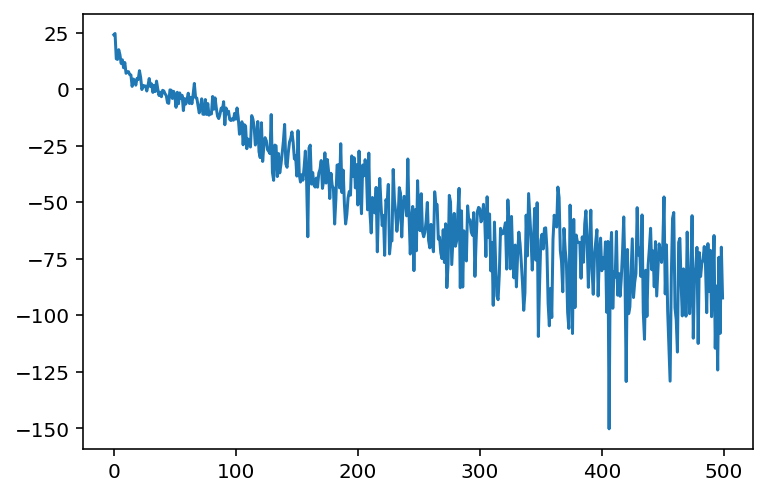

In [19]:
import matplotlib.pyplot as plt

fig, ax  = plt.subplots()
ax.plot(np.arange(len(losses_arr)), losses_arr)

## `tensorflow`:

In [24]:
import time
from src.l2hmc.configs import LossConfig
from src.l2hmc.loss.tensorflow.loss import LatticeLoss as tfLatticeLoss
from src.l2hmc.trainers.tensorflow.trainer import train_step as train_step_tf
from src.l2hmc.trainers.tensorflow.trainer import train_step as train_step_tf

from src.l2hmc.trainers.tensorflow.trainer import train_step as train_step_tf

optimizer_tf = tf.keras.optimizers.Adam()

dynamics_tf.compile(optimizer=optimizer_tf, loss=loss_tf)
train_step_tf_ = tf.function(train_step_tf)

In [25]:
xtf = tf.random.uniform(dynamics_tf.xshape, *(-np.pi, np.pi))
xtf = tf.reshape(xtf, (xtf.shape[0], -1))

losses_tf = {}
history_tf = {}
for era in range(10):
    losses_tf[str(era)] = []
    for epoch in range(100):
        start = time.time()
        xtf, metrics_tf = train_step_tf_((xtf, tf.constant(1.)),
                                         dynamics=dynamics_tf,
                                         optimizer=optimizer_tf,
                                         loss_fn=loss_tf)
        losses_tf[str(era)].append(metrics_tf['loss'])
        acc = tf.reduce_mean(metrics_tf['acc'])
        mstr = [f'epoch={epoch}', f'dt={time.time()-start:.3g}', f'loss={metrics_tf["loss"]:.3g}', f'acc={acc:.3g}']
        print(', '.join(mstr))
        for key, val in metrics_tf.items():
            try:
                history_tf[key].append(val)
            except KeyError:
                history_tf[key] = [val]
    
    print(f'era: {era}, avg_loss: {np.mean(losses_tf[str(era)]):.4g}')

epoch=0, dt=146, loss=-24.3, acc=0.799

epoch=1, dt=0.332, loss=-24.8, acc=0.863

epoch=2, dt=0.351, loss=-29.8, acc=0.721

epoch=3, dt=0.351, loss=-30.3, acc=0.773

epoch=4, dt=0.368, loss=-24.4, acc=0.774

epoch=5, dt=0.296, loss=-24.5, acc=0.726

epoch=6, dt=0.268, loss=-12.7, acc=0.66

epoch=7, dt=0.284, loss=-24.2, acc=0.71

epoch=8, dt=0.284, loss=-16.7, acc=0.62

epoch=9, dt=0.286, loss=-12.6, acc=0.602

epoch=10, dt=0.283, loss=-22.2, acc=0.486

epoch=11, dt=0.303, loss=-11.1, acc=0.508

epoch=12, dt=0.271, loss=-20.4, acc=0.516

epoch=13, dt=0.285, loss=-22.2, acc=0.47

epoch=14, dt=0.286, loss=-16.4, acc=0.496

epoch=15, dt=0.284, loss=-6.52, acc=0.494

epoch=16, dt=0.289, loss=-11, acc=0.474

epoch=17, dt=0.286, loss=-12, acc=0.439

epoch=18, dt=0.264, loss=-5.41, acc=0.506

epoch=19, dt=0.283, loss=-26.7, acc=0.474

epoch=20, dt=0.284, loss=-10.2, acc=0.453

epoch=21, dt=0.254, loss=-12.7, acc=0.447

epoch=22, dt=0.268, loss=-7.16, acc=0.503

epoch=23, dt=0.28, loss=-8.21, acc=0.473

epoch=24, dt=0.254, loss=-10.4, acc=0.489

epoch=25, dt=0.351, loss=-15, acc=0.506

epoch=26, dt=0.266, loss=-14.7, acc=0.55

epoch=27, dt=0.335, loss=-9.03, acc=0.432

epoch=28, dt=0.267, loss=-11.9, acc=0.504

epoch=29, dt=0.299, loss=-11.7, acc=0.487

epoch=30, dt=0.284, loss=-14.6, acc=0.499

epoch=31, dt=0.268, loss=-11.6, acc=0.53

epoch=32, dt=0.268, loss=-16.9, acc=0.546

epoch=33, dt=0.283, loss=-18.6, acc=0.599

epoch=34, dt=0.282, loss=-22.2, acc=0.553

epoch=35, dt=0.278, loss=-17.1, acc=0.596

epoch=36, dt=0.301, loss=-7.76, acc=0.621

epoch=37, dt=0.336, loss=-11.9, acc=0.58

epoch=38, dt=0.268, loss=-17, acc=0.589

epoch=39, dt=0.279, loss=-11.7, acc=0.548

epoch=40, dt=0.283, loss=-12.6, acc=0.564

epoch=41, dt=0.251, loss=-23.2, acc=0.686

epoch=42, dt=0.263, loss=-7.17, acc=0.576

epoch=43, dt=0.267, loss=-15.2, acc=0.635

epoch=44, dt=0.336, loss=-4.93, acc=0.624

epoch=45, dt=0.452, loss=-5.86, acc=0.574

epoch=46, dt=0.297, loss=-16.3, acc=0.642

epoch=47, dt=0.3, loss=-22.2, acc=0.608

epoch=48, dt=0.312, loss=-16.9, acc=0.584

epoch=49, dt=0.282, loss=-14.2, acc=0.612

epoch=50, dt=0.283, loss=-11, acc=0.612

epoch=51, dt=0.345, loss=-11.2, acc=0.607

epoch=52, dt=0.204, loss=-20.1, acc=0.628

epoch=53, dt=0.237, loss=-24.8, acc=0.665

epoch=54, dt=0.203, loss=-8.24, acc=0.592

epoch=55, dt=0.213, loss=-19.4, acc=0.643

epoch=56, dt=0.251, loss=-5.06, acc=0.618

epoch=57, dt=0.221, loss=-16.9, acc=0.612

epoch=58, dt=0.255, loss=-10.1, acc=0.565

epoch=59, dt=0.216, loss=-16.3, acc=0.614

epoch=60, dt=0.233, loss=-20.9, acc=0.617

epoch=61, dt=0.243, loss=-13.6, acc=0.602

epoch=62, dt=0.22, loss=-15.4, acc=0.658

epoch=63, dt=0.216, loss=-10.3, acc=0.612

epoch=64, dt=0.221, loss=-12.2, acc=0.616

epoch=65, dt=0.202, loss=-17.8, acc=0.644

epoch=66, dt=0.238, loss=-12.3, acc=0.601

epoch=67, dt=0.216, loss=-16.9, acc=0.612

epoch=68, dt=0.254, loss=-17.3, acc=0.664

epoch=69, dt=0.233, loss=-8.42, acc=0.638

epoch=70, dt=0.215, loss=-10.4, acc=0.596

epoch=71, dt=0.223, loss=-13.6, acc=0.695

epoch=72, dt=0.252, loss=-23.4, acc=0.721

epoch=73, dt=0.219, loss=-21.1, acc=0.648

epoch=74, dt=0.202, loss=-17.2, acc=0.655

epoch=75, dt=0.205, loss=-13.6, acc=0.677

epoch=76, dt=0.234, loss=-19, acc=0.684

epoch=77, dt=0.235, loss=-21.5, acc=0.702

epoch=78, dt=0.202, loss=-20.7, acc=0.723

epoch=79, dt=0.216, loss=-13.6, acc=0.617

epoch=80, dt=0.274, loss=-17.8, acc=0.649

epoch=81, dt=0.213, loss=-28.2, acc=0.651

epoch=82, dt=0.242, loss=-19.2, acc=0.643

epoch=83, dt=0.215, loss=-17.9, acc=0.663

epoch=84, dt=0.325, loss=-25.2, acc=0.751

epoch=85, dt=0.202, loss=-18.9, acc=0.668

epoch=86, dt=0.239, loss=-12.2, acc=0.622

epoch=87, dt=0.22, loss=-16.4, acc=0.636

epoch=88, dt=0.217, loss=-10, acc=0.618

epoch=89, dt=0.216, loss=-23.1, acc=0.7

epoch=90, dt=0.219, loss=-17.4, acc=0.687

epoch=91, dt=0.219, loss=-18.9, acc=0.675

epoch=92, dt=0.219, loss=-10.8, acc=0.699

epoch=93, dt=0.205, loss=-26.3, acc=0.76

epoch=94, dt=0.218, loss=-19.6, acc=0.694

epoch=95, dt=0.238, loss=-25.7, acc=0.757

epoch=96, dt=0.222, loss=-20.1, acc=0.689

epoch=97, dt=0.218, loss=-14.1, acc=0.666

epoch=98, dt=0.221, loss=-20.4, acc=0.712

epoch=99, dt=0.237, loss=-22.1, acc=0.709

era: 0, avg_loss: -16.24

epoch=0, dt=0.331, loss=-24.9, acc=0.716

epoch=1, dt=0.238, loss=-19.9, acc=0.745

epoch=2, dt=0.237, loss=-17.2, acc=0.755

epoch=3, dt=0.273, loss=-13.9, acc=0.703

epoch=4, dt=0.251, loss=-23.6, acc=0.675

epoch=5, dt=0.252, loss=-30.7, acc=0.691

epoch=6, dt=0.224, loss=-19, acc=0.694

epoch=7, dt=0.252, loss=-15, acc=0.714

epoch=8, dt=0.221, loss=-28.2, acc=0.684

epoch=9, dt=0.236, loss=-26.3, acc=0.697

epoch=10, dt=0.235, loss=-36.2, acc=0.73

epoch=11, dt=0.238, loss=-35.2, acc=0.75

epoch=12, dt=0.233, loss=-23.5, acc=0.683

epoch=13, dt=0.2, loss=-30.9, acc=0.743

epoch=14, dt=0.183, loss=-27.5, acc=0.727

epoch=15, dt=0.202, loss=-29.6, acc=0.756

epoch=16, dt=0.256, loss=-31.9, acc=0.68

epoch=17, dt=0.216, loss=-29.8, acc=0.762

epoch=18, dt=0.239, loss=-28.5, acc=0.771

epoch=19, dt=0.215, loss=-25.1, acc=0.731

epoch=20, dt=0.212, loss=-17.4, acc=0.744

epoch=21, dt=0.203, loss=-24.7, acc=0.712

epoch=22, dt=0.22, loss=-15.9, acc=0.696

epoch=23, dt=0.218, loss=-31.7, acc=0.722

epoch=24, dt=0.232, loss=-34.2, acc=0.715

epoch=25, dt=0.221, loss=-27.8, acc=0.711

epoch=26, dt=0.237, loss=-31.8, acc=0.745

epoch=27, dt=0.203, loss=-32.4, acc=0.744

epoch=28, dt=0.251, loss=-37.1, acc=0.713

epoch=29, dt=0.234, loss=-36, acc=0.714

epoch=30, dt=0.565, loss=-23.3, acc=0.754

epoch=31, dt=0.233, loss=-25.2, acc=0.765

epoch=32, dt=0.236, loss=-35.9, acc=0.689

epoch=33, dt=0.251, loss=-22.9, acc=0.646

epoch=34, dt=0.219, loss=-43.6, acc=0.69

epoch=35, dt=0.223, loss=-29.9, acc=0.745

epoch=36, dt=0.224, loss=-27.9, acc=0.712

epoch=37, dt=0.231, loss=-21.8, acc=0.709

epoch=38, dt=0.315, loss=-34.3, acc=0.696

epoch=39, dt=0.242, loss=-48.2, acc=0.687

epoch=40, dt=0.293, loss=-40.3, acc=0.661

epoch=41, dt=0.723, loss=-37, acc=0.682

epoch=42, dt=0.801, loss=-36.8, acc=0.716

epoch=43, dt=0.837, loss=-54.4, acc=0.69

epoch=44, dt=0.399, loss=-45.4, acc=0.76

epoch=45, dt=0.578, loss=-34.1, acc=0.799

epoch=46, dt=0.401, loss=-30, acc=0.675

epoch=47, dt=0.402, loss=-36.5, acc=0.753

epoch=48, dt=0.709, loss=-28, acc=0.661

epoch=49, dt=1.29, loss=-47.3, acc=0.764

epoch=50, dt=1.02, loss=-31.6, acc=0.701

epoch=51, dt=0.512, loss=-33.4, acc=0.684

epoch=52, dt=0.386, loss=-44.8, acc=0.767

epoch=53, dt=0.361, loss=-40.6, acc=0.722

epoch=54, dt=0.435, loss=-36.9, acc=0.714

epoch=55, dt=0.257, loss=-39.3, acc=0.742

epoch=56, dt=0.305, loss=-39.1, acc=0.711

epoch=57, dt=0.29, loss=-46.5, acc=0.774

epoch=58, dt=0.382, loss=-48.2, acc=0.734

epoch=59, dt=0.327, loss=-30.2, acc=0.72

epoch=60, dt=0.241, loss=-33.4, acc=0.732

epoch=61, dt=0.235, loss=-48, acc=0.775

epoch=62, dt=0.219, loss=-45.9, acc=0.794

epoch=63, dt=0.235, loss=-50, acc=0.729

epoch=64, dt=0.223, loss=-49.1, acc=0.741

epoch=65, dt=0.241, loss=-39.3, acc=0.708

epoch=66, dt=0.236, loss=-48.5, acc=0.728

epoch=67, dt=0.273, loss=-39.3, acc=0.814

epoch=68, dt=0.217, loss=-38.9, acc=0.745

epoch=69, dt=0.217, loss=-44.1, acc=0.749

epoch=70, dt=0.218, loss=-33.2, acc=0.726

epoch=71, dt=0.218, loss=-41.9, acc=0.692

epoch=72, dt=0.215, loss=-35.5, acc=0.735

epoch=73, dt=0.22, loss=-29.1, acc=0.72

epoch=74, dt=0.219, loss=-60.3, acc=0.737

epoch=75, dt=0.218, loss=-36.7, acc=0.752

epoch=76, dt=0.219, loss=-40.3, acc=0.645

epoch=77, dt=0.219, loss=-48.7, acc=0.711

epoch=78, dt=0.222, loss=-40.1, acc=0.71

epoch=79, dt=0.23, loss=-35.7, acc=0.696

epoch=80, dt=0.219, loss=-31.2, acc=0.696

epoch=81, dt=0.22, loss=-47.8, acc=0.68

epoch=82, dt=0.231, loss=-59.1, acc=0.727

epoch=83, dt=0.224, loss=-46.7, acc=0.746

epoch=84, dt=0.218, loss=-49.3, acc=0.754

epoch=85, dt=0.219, loss=-41.3, acc=0.716

epoch=86, dt=0.234, loss=-45.2, acc=0.744

epoch=87, dt=0.218, loss=-49.8, acc=0.769

epoch=88, dt=0.22, loss=-44.4, acc=0.782

epoch=89, dt=0.223, loss=-53.1, acc=0.717

epoch=90, dt=0.405, loss=-43.9, acc=0.738

epoch=91, dt=0.291, loss=-46.1, acc=0.714

epoch=92, dt=0.257, loss=-40.3, acc=0.757

epoch=93, dt=0.305, loss=-55.7, acc=0.764

epoch=94, dt=0.239, loss=-41.8, acc=0.778

epoch=95, dt=0.225, loss=-62.2, acc=0.738

epoch=96, dt=0.223, loss=-43.3, acc=0.747

epoch=97, dt=0.233, loss=-50.4, acc=0.763

epoch=98, dt=0.219, loss=-55.8, acc=0.784

epoch=99, dt=0.217, loss=-51, acc=0.736

era: 1, avg_loss: -36.96

epoch=0, dt=0.222, loss=-56, acc=0.747

epoch=1, dt=0.218, loss=-43.1, acc=0.732

epoch=2, dt=0.22, loss=-49.6, acc=0.816

epoch=3, dt=0.204, loss=-55, acc=0.803

epoch=4, dt=0.255, loss=-55.6, acc=0.79

epoch=5, dt=0.217, loss=-38.9, acc=0.746

epoch=6, dt=0.252, loss=-57.6, acc=0.776

epoch=7, dt=0.221, loss=-58.3, acc=0.76

epoch=8, dt=0.238, loss=-44.7, acc=0.82

epoch=9, dt=0.219, loss=-34.7, acc=0.828

epoch=10, dt=0.215, loss=-35.6, acc=0.77

epoch=11, dt=0.233, loss=-57.5, acc=0.776

epoch=12, dt=0.235, loss=-63.4, acc=0.759

epoch=13, dt=0.239, loss=-41.1, acc=0.75

epoch=14, dt=0.291, loss=-54, acc=0.753

epoch=15, dt=0.27, loss=-38.1, acc=0.696

epoch=16, dt=0.235, loss=-36.9, acc=0.697

epoch=17, dt=0.235, loss=-89.6, acc=0.839

epoch=18, dt=0.235, loss=-61.7, acc=0.803

epoch=19, dt=0.235, loss=-46.7, acc=0.736

epoch=20, dt=0.255, loss=-50.8, acc=0.754

epoch=21, dt=0.22, loss=-59.6, acc=0.753

epoch=22, dt=0.34, loss=-70.2, acc=0.79

epoch=23, dt=0.234, loss=-52.5, acc=0.744

epoch=24, dt=0.221, loss=-44.8, acc=0.765

epoch=25, dt=0.252, loss=-46.5, acc=0.782

epoch=26, dt=0.202, loss=-44, acc=0.823

epoch=27, dt=0.238, loss=-42.2, acc=0.803

epoch=28, dt=0.184, loss=-50.9, acc=0.824

epoch=29, dt=0.182, loss=-59.2, acc=0.781

epoch=30, dt=0.313, loss=-68, acc=0.753

epoch=31, dt=0.203, loss=-72.9, acc=0.799

epoch=32, dt=0.179, loss=-39.3, acc=0.791

epoch=33, dt=0.179, loss=-45.3, acc=0.78

epoch=34, dt=0.194, loss=-54, acc=0.77

epoch=35, dt=0.194, loss=-41.6, acc=0.773

epoch=36, dt=0.181, loss=-53.7, acc=0.76

epoch=37, dt=0.178, loss=-48.4, acc=0.778

epoch=38, dt=0.179, loss=-60.2, acc=0.789

epoch=39, dt=0.195, loss=-39.5, acc=0.746

epoch=40, dt=0.195, loss=-65.1, acc=0.761

epoch=41, dt=0.182, loss=-66.5, acc=0.82

epoch=42, dt=0.177, loss=-62.5, acc=0.802

epoch=43, dt=0.179, loss=-56.6, acc=0.787

epoch=44, dt=0.179, loss=-74.1, acc=0.759

epoch=45, dt=0.205, loss=-60.4, acc=0.841

epoch=46, dt=0.182, loss=-56.1, acc=0.767

epoch=47, dt=0.175, loss=-59.5, acc=0.776

epoch=48, dt=0.179, loss=-57.9, acc=0.775

epoch=49, dt=0.198, loss=-60, acc=0.791

epoch=50, dt=0.179, loss=-57.9, acc=0.787

epoch=51, dt=0.176, loss=-41.5, acc=0.83

epoch=52, dt=0.205, loss=-66.3, acc=0.773

epoch=53, dt=0.178, loss=-67.3, acc=0.788

epoch=54, dt=0.181, loss=-63.7, acc=0.726

epoch=55, dt=0.183, loss=-63.3, acc=0.817

epoch=56, dt=0.182, loss=-54.6, acc=0.748

epoch=57, dt=0.214, loss=-59.9, acc=0.75

epoch=58, dt=0.192, loss=-72.1, acc=0.78

epoch=59, dt=0.193, loss=-89.3, acc=0.79

epoch=60, dt=0.267, loss=-51.2, acc=0.828

epoch=61, dt=0.194, loss=-40.4, acc=0.74

epoch=62, dt=0.192, loss=-56.2, acc=0.812

epoch=63, dt=0.177, loss=-39.9, acc=0.769

epoch=64, dt=0.196, loss=-48.2, acc=0.84

epoch=65, dt=0.197, loss=-76.9, acc=0.774

epoch=66, dt=0.181, loss=-61.8, acc=0.762

epoch=67, dt=0.197, loss=-49.4, acc=0.766

epoch=68, dt=0.247, loss=-46.5, acc=0.75

epoch=69, dt=0.198, loss=-39.9, acc=0.773

epoch=70, dt=0.222, loss=-48.3, acc=0.82

epoch=71, dt=0.22, loss=-62, acc=0.813

epoch=72, dt=0.272, loss=-84.4, acc=0.785

epoch=73, dt=0.178, loss=-61.1, acc=0.853

epoch=74, dt=0.22, loss=-56.3, acc=0.765

epoch=75, dt=0.2, loss=-57, acc=0.742

epoch=76, dt=0.182, loss=-81.1, acc=0.763

epoch=77, dt=0.224, loss=-66.2, acc=0.781

epoch=78, dt=0.22, loss=-46.8, acc=0.782

epoch=79, dt=0.193, loss=-81.9, acc=0.735

epoch=80, dt=0.2, loss=-86.5, acc=0.753

epoch=81, dt=0.177, loss=-63.4, acc=0.753

epoch=82, dt=0.181, loss=-55.8, acc=0.744

epoch=83, dt=0.223, loss=-68.8, acc=0.777

epoch=84, dt=0.187, loss=-54.5, acc=0.762

epoch=85, dt=0.196, loss=-67.3, acc=0.727

epoch=86, dt=0.177, loss=-48.1, acc=0.785

epoch=87, dt=0.223, loss=-83.8, acc=0.774

epoch=88, dt=0.195, loss=-86.2, acc=0.835

epoch=89, dt=0.195, loss=-51.4, acc=0.803

epoch=90, dt=0.196, loss=-66.1, acc=0.773

epoch=91, dt=0.2, loss=-63.5, acc=0.746

epoch=92, dt=0.198, loss=-56.5, acc=0.822

epoch=93, dt=0.17, loss=-58.1, acc=0.747

epoch=94, dt=0.198, loss=-73, acc=0.827

epoch=95, dt=0.175, loss=-73.4, acc=0.806

epoch=96, dt=0.187, loss=-64.9, acc=0.811

epoch=97, dt=0.194, loss=-63.1, acc=0.816

epoch=98, dt=0.263, loss=-73.4, acc=0.821

epoch=99, dt=0.183, loss=-86.8, acc=0.817

era: 2, avg_loss: -58.17

epoch=0, dt=0.198, loss=-68.9, acc=0.764

epoch=1, dt=0.22, loss=-78.2, acc=0.812

epoch=2, dt=0.18, loss=-73.2, acc=0.778

epoch=3, dt=0.188, loss=-78, acc=0.76

epoch=4, dt=0.198, loss=-77.9, acc=0.814

epoch=5, dt=0.196, loss=-74.5, acc=0.757

epoch=6, dt=0.199, loss=-64.8, acc=0.757

epoch=7, dt=0.221, loss=-68.2, acc=0.804

epoch=8, dt=0.207, loss=-61.6, acc=0.827

epoch=9, dt=0.179, loss=-50.5, acc=0.76

epoch=10, dt=0.182, loss=-59.5, acc=0.738

epoch=11, dt=0.196, loss=-62.7, acc=0.792

epoch=12, dt=0.185, loss=-80.9, acc=0.808

epoch=13, dt=0.199, loss=-72, acc=0.78

epoch=14, dt=0.334, loss=-66, acc=0.808

epoch=15, dt=0.222, loss=-70.5, acc=0.763

epoch=16, dt=0.249, loss=-86.3, acc=0.775

epoch=17, dt=0.184, loss=-85.1, acc=0.768

epoch=18, dt=0.217, loss=-86.8, acc=0.775

epoch=19, dt=0.237, loss=-56.4, acc=0.754

epoch=20, dt=0.261, loss=-43.5, acc=0.78

epoch=21, dt=0.228, loss=-77.6, acc=0.843

epoch=22, dt=0.196, loss=-59.5, acc=0.832

epoch=23, dt=0.253, loss=-62.5, acc=0.733

epoch=24, dt=0.205, loss=-73.3, acc=0.844

epoch=25, dt=0.18, loss=-69.8, acc=0.737

epoch=26, dt=0.264, loss=-53.3, acc=0.751

epoch=27, dt=0.186, loss=-80.1, acc=0.804

epoch=28, dt=0.27, loss=-85.7, acc=0.775

epoch=29, dt=0.216, loss=-64.9, acc=0.797

epoch=30, dt=0.237, loss=-73.3, acc=0.799

epoch=31, dt=0.218, loss=-67.8, acc=0.799

epoch=32, dt=0.176, loss=-56.8, acc=0.78

epoch=33, dt=0.223, loss=-86.7, acc=0.78

epoch=34, dt=0.183, loss=-79.8, acc=0.82

epoch=35, dt=0.177, loss=-70.9, acc=0.845

epoch=36, dt=0.185, loss=-76, acc=0.806

epoch=37, dt=0.176, loss=-76.2, acc=0.805

epoch=38, dt=0.172, loss=-93.1, acc=0.799

epoch=39, dt=0.175, loss=-70.1, acc=0.817

epoch=40, dt=0.224, loss=-77.3, acc=0.798

epoch=41, dt=0.282, loss=-80.2, acc=0.868

epoch=42, dt=0.183, loss=-37.9, acc=0.819

epoch=43, dt=0.205, loss=-59, acc=0.823

epoch=44, dt=0.183, loss=-91.7, acc=0.828

epoch=45, dt=0.199, loss=-77.6, acc=0.838

epoch=46, dt=0.201, loss=-75.9, acc=0.857

epoch=47, dt=0.2, loss=-77.9, acc=0.837

epoch=48, dt=0.2, loss=-87.6, acc=0.834

epoch=49, dt=0.182, loss=-71.4, acc=0.819

epoch=50, dt=0.181, loss=-74.4, acc=0.815

epoch=51, dt=0.205, loss=-110, acc=0.803

epoch=52, dt=0.196, loss=-84.4, acc=0.805

epoch=53, dt=0.18, loss=-95.7, acc=0.83

epoch=54, dt=0.177, loss=-71.6, acc=0.813

epoch=55, dt=0.155, loss=-96.5, acc=0.848

epoch=56, dt=0.155, loss=-86.3, acc=0.851

epoch=57, dt=0.177, loss=-69.9, acc=0.813

epoch=58, dt=0.204, loss=-120, acc=0.873

epoch=59, dt=0.18, loss=-74.3, acc=0.83

epoch=60, dt=0.224, loss=-52.5, acc=0.837

epoch=61, dt=0.177, loss=-79.9, acc=0.828

epoch=62, dt=0.185, loss=-59.8, acc=0.826

epoch=63, dt=0.205, loss=-56.8, acc=0.872

epoch=64, dt=0.194, loss=-75.5, acc=0.794

epoch=65, dt=0.22, loss=-85.1, acc=0.841

epoch=66, dt=0.194, loss=-76.9, acc=0.825

epoch=67, dt=0.184, loss=-84.5, acc=0.806

epoch=68, dt=0.183, loss=-70.4, acc=0.854

epoch=69, dt=0.202, loss=-70.2, acc=0.811

epoch=70, dt=0.226, loss=-67.6, acc=0.848

epoch=71, dt=0.185, loss=-50.1, acc=0.802

epoch=72, dt=0.226, loss=-63.2, acc=0.811

epoch=73, dt=0.22, loss=-51.9, acc=0.869

epoch=74, dt=0.194, loss=-80.2, acc=0.816

epoch=75, dt=0.164, loss=-89.5, acc=0.808

epoch=76, dt=0.172, loss=-93.2, acc=0.803

epoch=77, dt=0.171, loss=-98.7, acc=0.833

epoch=78, dt=0.179, loss=-85.5, acc=0.783

epoch=79, dt=0.178, loss=-79.4, acc=0.792

epoch=80, dt=0.178, loss=-99.7, acc=0.84

epoch=81, dt=0.176, loss=-68.2, acc=0.816

epoch=82, dt=0.192, loss=-53.7, acc=0.771

epoch=83, dt=0.181, loss=-87.8, acc=0.826

epoch=84, dt=0.155, loss=-78.7, acc=0.853

epoch=85, dt=0.171, loss=-79.1, acc=0.819

epoch=86, dt=0.173, loss=-103, acc=0.842

epoch=87, dt=0.193, loss=-68.4, acc=0.819

epoch=88, dt=0.156, loss=-82.9, acc=0.852

epoch=89, dt=0.203, loss=-67.4, acc=0.825

epoch=90, dt=0.203, loss=-72.3, acc=0.848

epoch=91, dt=0.177, loss=-68.2, acc=0.812

epoch=92, dt=0.222, loss=-70.7, acc=0.827

epoch=93, dt=0.245, loss=-100, acc=0.83

epoch=94, dt=0.204, loss=-113, acc=0.873

epoch=95, dt=0.244, loss=-96.1, acc=0.804

epoch=96, dt=0.204, loss=-109, acc=0.84

epoch=97, dt=0.291, loss=-58.7, acc=0.82

epoch=98, dt=0.217, loss=-92.2, acc=0.812

epoch=99, dt=0.217, loss=-83, acc=0.852

era: 3, avg_loss: -75.85

epoch=0, dt=0.185, loss=-77.3, acc=0.815

epoch=1, dt=0.179, loss=-109, acc=0.828

epoch=2, dt=0.197, loss=-80.6, acc=0.821

epoch=3, dt=0.197, loss=-68.2, acc=0.809

epoch=4, dt=0.222, loss=-78.6, acc=0.813

epoch=5, dt=0.222, loss=-86.2, acc=0.821

epoch=6, dt=0.222, loss=-93.9, acc=0.848

epoch=7, dt=0.213, loss=-67.3, acc=0.821

epoch=8, dt=0.227, loss=-80.2, acc=0.848

epoch=9, dt=0.316, loss=-122, acc=0.834

epoch=10, dt=0.199, loss=-116, acc=0.831

epoch=11, dt=0.184, loss=-88, acc=0.819

epoch=12, dt=0.178, loss=-71.3, acc=0.831

epoch=13, dt=0.209, loss=-94.5, acc=0.801

epoch=14, dt=0.182, loss=-103, acc=0.845

epoch=15, dt=0.196, loss=-94.7, acc=0.859

epoch=16, dt=0.226, loss=-83.7, acc=0.825

epoch=17, dt=0.178, loss=-85, acc=0.849

epoch=18, dt=0.166, loss=-99.2, acc=0.84

epoch=19, dt=0.181, loss=-105, acc=0.846

epoch=20, dt=0.2, loss=-64.8, acc=0.857

epoch=21, dt=0.2, loss=-90.7, acc=0.811

epoch=22, dt=0.196, loss=-82.2, acc=0.825

epoch=23, dt=0.197, loss=-46.7, acc=0.854

epoch=24, dt=0.202, loss=-81, acc=0.847

epoch=25, dt=0.193, loss=-74.1, acc=0.818

epoch=26, dt=0.179, loss=-87.3, acc=0.865

epoch=27, dt=0.161, loss=-76, acc=0.801

epoch=28, dt=0.156, loss=-74.2, acc=0.807

epoch=29, dt=0.153, loss=-65.5, acc=0.85

epoch=30, dt=0.2, loss=-106, acc=0.866

epoch=31, dt=0.172, loss=-99.3, acc=0.816

epoch=32, dt=0.18, loss=-97.8, acc=0.838

epoch=33, dt=0.177, loss=-91.6, acc=0.857

epoch=34, dt=0.164, loss=-96.5, acc=0.849

epoch=35, dt=0.175, loss=-75.2, acc=0.89

epoch=36, dt=0.178, loss=-70, acc=0.79

epoch=37, dt=0.158, loss=-97.7, acc=0.851

epoch=38, dt=0.181, loss=-110, acc=0.849

epoch=39, dt=0.168, loss=-68.7, acc=0.837

epoch=40, dt=0.158, loss=-68, acc=0.864

epoch=41, dt=0.197, loss=-85.7, acc=0.861

epoch=42, dt=0.173, loss=-66.6, acc=0.812

epoch=43, dt=0.186, loss=-67.9, acc=0.836

epoch=44, dt=0.179, loss=-88.2, acc=0.842

epoch=45, dt=0.186, loss=-70.5, acc=0.84

epoch=46, dt=0.175, loss=-74.3, acc=0.873

epoch=47, dt=0.263, loss=-85.9, acc=0.826

epoch=48, dt=0.179, loss=-82.2, acc=0.849

epoch=49, dt=0.179, loss=-80.6, acc=0.863

epoch=50, dt=0.241, loss=-90.6, acc=0.848

epoch=51, dt=0.205, loss=-86.7, acc=0.852

epoch=52, dt=0.178, loss=-75.6, acc=0.834

epoch=53, dt=0.195, loss=-93.7, acc=0.805

epoch=54, dt=0.175, loss=-62.5, acc=0.787

epoch=55, dt=0.244, loss=-96, acc=0.876

epoch=56, dt=0.195, loss=-93.9, acc=0.858

epoch=57, dt=0.195, loss=-92.4, acc=0.88

epoch=58, dt=0.235, loss=-91, acc=0.877

epoch=59, dt=0.196, loss=-86.7, acc=0.869

epoch=60, dt=0.181, loss=-69, acc=0.836

epoch=61, dt=0.184, loss=-76, acc=0.862

epoch=62, dt=0.176, loss=-93.7, acc=0.891

epoch=63, dt=0.242, loss=-89.9, acc=0.839

epoch=64, dt=0.18, loss=-57.7, acc=0.85

epoch=65, dt=0.18, loss=-85.3, acc=0.841

epoch=66, dt=0.213, loss=-73.5, acc=0.868

epoch=67, dt=0.181, loss=-82.9, acc=0.847

epoch=68, dt=0.162, loss=-112, acc=0.885

epoch=69, dt=0.175, loss=-118, acc=0.864

epoch=70, dt=0.158, loss=-121, acc=0.861

epoch=71, dt=0.181, loss=-72.4, acc=0.889

epoch=72, dt=0.177, loss=-81.9, acc=0.87

epoch=73, dt=0.153, loss=-110, acc=0.879

epoch=74, dt=0.159, loss=-114, acc=0.902

epoch=75, dt=0.156, loss=-78.1, acc=0.888

epoch=76, dt=0.174, loss=-111, acc=0.909

epoch=77, dt=0.179, loss=-66.4, acc=0.832

epoch=78, dt=0.188, loss=-84.6, acc=0.877

epoch=79, dt=0.195, loss=-78.3, acc=0.815

epoch=80, dt=0.177, loss=-80.1, acc=0.841

epoch=81, dt=0.226, loss=-61.3, acc=0.835

epoch=82, dt=0.161, loss=-84.6, acc=0.861

epoch=83, dt=0.178, loss=-90.8, acc=0.854

epoch=84, dt=0.177, loss=-76, acc=0.855

epoch=85, dt=0.182, loss=-97.2, acc=0.874

epoch=86, dt=0.18, loss=-80.8, acc=0.865

epoch=87, dt=0.182, loss=-77.6, acc=0.861

epoch=88, dt=0.194, loss=-96.6, acc=0.867

epoch=89, dt=0.214, loss=-86.3, acc=0.858

epoch=90, dt=0.238, loss=-95.6, acc=0.905

epoch=91, dt=0.176, loss=-75.3, acc=0.834

epoch=92, dt=0.203, loss=-52.6, acc=0.885

epoch=93, dt=0.18, loss=-62.2, acc=0.858

epoch=94, dt=0.199, loss=-93.7, acc=0.868

epoch=95, dt=0.244, loss=-96.7, acc=0.878

epoch=96, dt=0.197, loss=-84.5, acc=0.857

epoch=97, dt=0.184, loss=-94.7, acc=0.881

epoch=98, dt=0.217, loss=-86.9, acc=0.877

epoch=99, dt=0.226, loss=-62.2, acc=0.878

era: 4, avg_loss: -85.1

epoch=0, dt=0.203, loss=-75.9, acc=0.879

epoch=1, dt=0.178, loss=-87.5, acc=0.856

epoch=2, dt=0.244, loss=-94.9, acc=0.87

epoch=3, dt=0.195, loss=-121, acc=0.872

epoch=4, dt=0.222, loss=-81.5, acc=0.846

epoch=5, dt=0.223, loss=-109, acc=0.873

epoch=6, dt=0.197, loss=-65.3, acc=0.881

epoch=7, dt=0.196, loss=-76.1, acc=0.864

epoch=8, dt=0.182, loss=-88.8, acc=0.842

epoch=9, dt=0.181, loss=-76.1, acc=0.877

epoch=10, dt=0.177, loss=-77.4, acc=0.854

epoch=11, dt=0.181, loss=-88, acc=0.846

epoch=12, dt=0.185, loss=-68.3, acc=0.878

epoch=13, dt=0.182, loss=-95.6, acc=0.871

epoch=14, dt=0.196, loss=-115, acc=0.869

epoch=15, dt=0.18, loss=-98.9, acc=0.878

epoch=16, dt=0.175, loss=-113, acc=0.875

epoch=17, dt=0.177, loss=-120, acc=0.896

epoch=18, dt=0.223, loss=-103, acc=0.893

epoch=19, dt=0.159, loss=-93.7, acc=0.892

epoch=20, dt=0.204, loss=-84.7, acc=0.901

epoch=21, dt=0.178, loss=-119, acc=0.865

epoch=22, dt=0.207, loss=-90, acc=0.863

epoch=23, dt=0.306, loss=-81.1, acc=0.879

epoch=24, dt=0.235, loss=-77.8, acc=0.86

epoch=25, dt=0.244, loss=-91.8, acc=0.892

epoch=26, dt=0.179, loss=-84.4, acc=0.876

epoch=27, dt=0.251, loss=-85.2, acc=0.881

epoch=28, dt=0.2, loss=-114, acc=0.886

epoch=29, dt=0.183, loss=-84.4, acc=0.851

epoch=30, dt=0.206, loss=-89.8, acc=0.884

epoch=31, dt=0.181, loss=-84.8, acc=0.881

epoch=32, dt=0.246, loss=-75, acc=0.898

epoch=33, dt=0.177, loss=-74.1, acc=0.868

epoch=34, dt=0.164, loss=-97.3, acc=0.891

epoch=35, dt=0.199, loss=-116, acc=0.874

epoch=36, dt=0.183, loss=-78, acc=0.87

epoch=37, dt=0.176, loss=-102, acc=0.839

epoch=38, dt=0.164, loss=-88.2, acc=0.891

epoch=39, dt=0.201, loss=-107, acc=0.841

epoch=40, dt=0.162, loss=-87.4, acc=0.851

epoch=41, dt=0.178, loss=-75.6, acc=0.849

epoch=42, dt=0.189, loss=-86.5, acc=0.82

epoch=43, dt=0.196, loss=-103, acc=0.857

epoch=44, dt=0.176, loss=-109, acc=0.891

epoch=45, dt=0.185, loss=-83, acc=0.819

epoch=46, dt=0.223, loss=-111, acc=0.9

epoch=47, dt=0.173, loss=-127, acc=0.898

epoch=48, dt=0.173, loss=-116, acc=0.83

epoch=49, dt=0.171, loss=-110, acc=0.884

epoch=50, dt=0.245, loss=-94.2, acc=0.855

epoch=51, dt=0.199, loss=-90.4, acc=0.816

epoch=52, dt=0.228, loss=-116, acc=0.898

epoch=53, dt=0.243, loss=-82.4, acc=0.85

epoch=54, dt=0.273, loss=-84.4, acc=0.898

epoch=55, dt=0.308, loss=-73.4, acc=0.851

epoch=56, dt=0.296, loss=-90.1, acc=0.859

epoch=57, dt=0.224, loss=-85.1, acc=0.884

epoch=58, dt=0.243, loss=-91.6, acc=0.815

epoch=59, dt=0.217, loss=-89.2, acc=0.867

epoch=60, dt=0.194, loss=-74.7, acc=0.873

epoch=61, dt=0.176, loss=-107, acc=0.87

epoch=62, dt=0.203, loss=-163, acc=0.862

epoch=63, dt=0.228, loss=-134, acc=0.881

epoch=64, dt=0.2, loss=-91.4, acc=0.83

epoch=65, dt=0.193, loss=-100, acc=0.861

epoch=66, dt=0.18, loss=-93.7, acc=0.902

epoch=67, dt=0.2, loss=-69.9, acc=0.847

epoch=68, dt=0.194, loss=-70.5, acc=0.881

epoch=69, dt=0.2, loss=-74.8, acc=0.888

epoch=70, dt=0.183, loss=-79.8, acc=0.883

epoch=71, dt=0.224, loss=-64, acc=0.849

epoch=72, dt=0.198, loss=-98.1, acc=0.853

epoch=73, dt=0.178, loss=-106, acc=0.845

epoch=74, dt=0.238, loss=-88.8, acc=0.898

epoch=75, dt=0.194, loss=-75.5, acc=0.831

epoch=76, dt=0.186, loss=-91.8, acc=0.846

epoch=77, dt=0.18, loss=-99.7, acc=0.887

epoch=78, dt=0.176, loss=-139, acc=0.873

epoch=79, dt=0.183, loss=-110, acc=0.89

epoch=80, dt=0.22, loss=-89.7, acc=0.891

epoch=81, dt=0.198, loss=-99.4, acc=0.878

epoch=82, dt=0.182, loss=-108, acc=0.861

epoch=83, dt=0.222, loss=-85, acc=0.85

epoch=84, dt=0.248, loss=-92.1, acc=0.848

epoch=85, dt=0.268, loss=-90.4, acc=0.868

epoch=86, dt=0.201, loss=-84.2, acc=0.861

epoch=87, dt=0.198, loss=-102, acc=0.845

epoch=88, dt=0.196, loss=-65.9, acc=0.816

epoch=89, dt=0.204, loss=-117, acc=0.86

epoch=90, dt=0.181, loss=-103, acc=0.885

epoch=91, dt=0.266, loss=-86, acc=0.817

epoch=92, dt=0.198, loss=-106, acc=0.864

epoch=93, dt=0.199, loss=-82.5, acc=0.889

epoch=94, dt=0.204, loss=-71.4, acc=0.848

epoch=95, dt=0.182, loss=-112, acc=0.876

epoch=96, dt=0.202, loss=-106, acc=0.889

epoch=97, dt=0.291, loss=-81.8, acc=0.835

epoch=98, dt=0.184, loss=-99.9, acc=0.883

epoch=99, dt=0.178, loss=-88.1, acc=0.822

era: 5, avg_loss: -93.86

epoch=0, dt=0.219, loss=-92.2, acc=0.84

epoch=1, dt=0.202, loss=-67.1, acc=0.873

epoch=2, dt=0.251, loss=-85.1, acc=0.872

epoch=3, dt=0.196, loss=-87.8, acc=0.861

epoch=4, dt=0.194, loss=-99.4, acc=0.877

epoch=5, dt=0.165, loss=-75.3, acc=0.858

epoch=6, dt=0.178, loss=-109, acc=0.848

epoch=7, dt=0.22, loss=-81, acc=0.872

epoch=8, dt=0.193, loss=-76.8, acc=0.828

epoch=9, dt=0.172, loss=-102, acc=0.892

epoch=10, dt=0.231, loss=-125, acc=0.876

epoch=11, dt=0.245, loss=-117, acc=0.838

epoch=12, dt=0.183, loss=-99.1, acc=0.893

epoch=13, dt=0.179, loss=-108, acc=0.869

epoch=14, dt=0.184, loss=-61.9, acc=0.887

epoch=15, dt=0.219, loss=-99.6, acc=0.898

epoch=16, dt=0.202, loss=-94.8, acc=0.903

epoch=17, dt=0.181, loss=-105, acc=0.879

epoch=18, dt=0.178, loss=-117, acc=0.859

epoch=19, dt=0.179, loss=-94.7, acc=0.894

epoch=20, dt=0.181, loss=-80.4, acc=0.833

epoch=21, dt=0.181, loss=-90.8, acc=0.851

epoch=22, dt=0.201, loss=-112, acc=0.876

epoch=23, dt=0.2, loss=-104, acc=0.861

epoch=24, dt=0.185, loss=-88.9, acc=0.876

epoch=25, dt=0.195, loss=-99.2, acc=0.878

epoch=26, dt=0.219, loss=-68, acc=0.858

epoch=27, dt=0.164, loss=-77.6, acc=0.906

epoch=28, dt=0.194, loss=-89.6, acc=0.854

epoch=29, dt=0.176, loss=-103, acc=0.856

epoch=30, dt=0.165, loss=-69.5, acc=0.877

epoch=31, dt=0.197, loss=-79.3, acc=0.871

epoch=32, dt=0.228, loss=-79.1, acc=0.864

epoch=33, dt=0.198, loss=-91.2, acc=0.87

epoch=34, dt=0.222, loss=-108, acc=0.879

epoch=35, dt=0.244, loss=-92, acc=0.835

epoch=36, dt=0.179, loss=-82.8, acc=0.901

epoch=37, dt=0.204, loss=-88.8, acc=0.846

epoch=38, dt=0.313, loss=-112, acc=0.852

epoch=39, dt=0.2, loss=-99.5, acc=0.853

epoch=40, dt=0.273, loss=-130, acc=0.905

epoch=41, dt=0.199, loss=-82.9, acc=0.894

epoch=42, dt=0.18, loss=-115, acc=0.902

epoch=43, dt=0.177, loss=-109, acc=0.881

epoch=44, dt=0.179, loss=-96.7, acc=0.885

epoch=45, dt=0.198, loss=-92.8, acc=0.879

epoch=46, dt=0.243, loss=-106, acc=0.835

epoch=47, dt=0.175, loss=-82.8, acc=0.855

epoch=48, dt=0.182, loss=-84.1, acc=0.89

epoch=49, dt=0.246, loss=-106, acc=0.863

epoch=50, dt=0.194, loss=-98.3, acc=0.878

epoch=51, dt=0.178, loss=-113, acc=0.877

epoch=52, dt=0.199, loss=-80.2, acc=0.843

epoch=53, dt=0.2, loss=-102, acc=0.882

epoch=54, dt=0.176, loss=-109, acc=0.909

epoch=55, dt=0.191, loss=-90.4, acc=0.855

epoch=56, dt=0.176, loss=-89, acc=0.862

epoch=57, dt=0.177, loss=-64.4, acc=0.88

epoch=58, dt=0.184, loss=-106, acc=0.89

epoch=59, dt=0.177, loss=-97.1, acc=0.836

epoch=60, dt=0.185, loss=-123, acc=0.894

epoch=61, dt=0.178, loss=-94.5, acc=0.848

epoch=62, dt=0.178, loss=-107, acc=0.891

epoch=63, dt=0.184, loss=-77.9, acc=0.874

epoch=64, dt=0.178, loss=-104, acc=0.895

epoch=65, dt=0.227, loss=-103, acc=0.871

epoch=66, dt=0.176, loss=-103, acc=0.887

epoch=67, dt=0.176, loss=-115, acc=0.862

epoch=68, dt=0.174, loss=-117, acc=0.895

epoch=69, dt=0.198, loss=-120, acc=0.919

epoch=70, dt=0.183, loss=-113, acc=0.882

epoch=71, dt=0.193, loss=-96.4, acc=0.874

epoch=72, dt=0.191, loss=-103, acc=0.874

epoch=73, dt=0.243, loss=-107, acc=0.869

epoch=74, dt=0.242, loss=-103, acc=0.892

epoch=75, dt=0.179, loss=-95, acc=0.869

epoch=76, dt=0.244, loss=-97.4, acc=0.898

epoch=77, dt=0.188, loss=-113, acc=0.873

epoch=78, dt=0.177, loss=-126, acc=0.86

epoch=79, dt=0.184, loss=-92.2, acc=0.879

epoch=80, dt=0.182, loss=-108, acc=0.888

epoch=81, dt=0.196, loss=-129, acc=0.867

epoch=82, dt=0.183, loss=-78.7, acc=0.903

epoch=83, dt=0.197, loss=-100, acc=0.841

epoch=84, dt=0.246, loss=-66.8, acc=0.86

epoch=85, dt=0.201, loss=-80.1, acc=0.901

epoch=86, dt=0.204, loss=-118, acc=0.85

epoch=87, dt=0.183, loss=-98.2, acc=0.858

epoch=88, dt=0.2, loss=-107, acc=0.863

epoch=89, dt=0.24, loss=-103, acc=0.878

epoch=90, dt=0.194, loss=-92, acc=0.844

epoch=91, dt=0.19, loss=-114, acc=0.894

epoch=92, dt=0.193, loss=-91, acc=0.873

epoch=93, dt=0.199, loss=-97.6, acc=0.905

epoch=94, dt=0.181, loss=-84.4, acc=0.867

epoch=95, dt=0.178, loss=-125, acc=0.906

epoch=96, dt=0.182, loss=-103, acc=0.888

epoch=97, dt=0.18, loss=-125, acc=0.913

epoch=98, dt=0.237, loss=-104, acc=0.895

epoch=99, dt=0.179, loss=-145, acc=0.876

era: 6, avg_loss: -98.46

epoch=0, dt=0.175, loss=-114, acc=0.871

epoch=1, dt=0.18, loss=-103, acc=0.886

epoch=2, dt=0.2, loss=-110, acc=0.862

epoch=3, dt=0.179, loss=-75.7, acc=0.892

epoch=4, dt=0.264, loss=-126, acc=0.887

epoch=5, dt=0.224, loss=-118, acc=0.908

epoch=6, dt=0.179, loss=-98.1, acc=0.871

epoch=7, dt=0.196, loss=-132, acc=0.888

epoch=8, dt=0.174, loss=-72.9, acc=0.87

epoch=9, dt=0.16, loss=-72.5, acc=0.868

epoch=10, dt=0.164, loss=-89.8, acc=0.871

epoch=11, dt=0.162, loss=-88.9, acc=0.853

epoch=12, dt=0.187, loss=-125, acc=0.885

epoch=13, dt=0.178, loss=-101, acc=0.879

epoch=14, dt=0.179, loss=-113, acc=0.854

epoch=15, dt=0.224, loss=-143, acc=0.876

epoch=16, dt=0.175, loss=-117, acc=0.876

epoch=17, dt=0.178, loss=-94.7, acc=0.893

epoch=18, dt=0.175, loss=-82.1, acc=0.888

epoch=19, dt=0.163, loss=-75.6, acc=0.896

epoch=20, dt=0.176, loss=-113, acc=0.858

epoch=21, dt=0.219, loss=-77.7, acc=0.875

epoch=22, dt=0.164, loss=-98.3, acc=0.914

epoch=23, dt=0.175, loss=-123, acc=0.901

epoch=24, dt=0.179, loss=-101, acc=0.884

epoch=25, dt=0.183, loss=-77.4, acc=0.872

epoch=26, dt=0.193, loss=-96.1, acc=0.851

epoch=27, dt=0.19, loss=-117, acc=0.86

epoch=28, dt=0.194, loss=-90.1, acc=0.855

epoch=29, dt=0.172, loss=-119, acc=0.901

epoch=30, dt=0.178, loss=-115, acc=0.87

epoch=31, dt=0.161, loss=-102, acc=0.801

epoch=32, dt=0.18, loss=-127, acc=0.875

epoch=33, dt=0.171, loss=-132, acc=0.91

epoch=34, dt=0.172, loss=-106, acc=0.887

epoch=35, dt=0.173, loss=-107, acc=0.877

epoch=36, dt=0.166, loss=-110, acc=0.868

epoch=37, dt=0.176, loss=-110, acc=0.861

epoch=38, dt=0.172, loss=-153, acc=0.883

epoch=39, dt=0.16, loss=-117, acc=0.854

epoch=40, dt=0.154, loss=-96.3, acc=0.877

epoch=41, dt=0.178, loss=-101, acc=0.88

epoch=42, dt=0.155, loss=-130, acc=0.9

epoch=43, dt=0.174, loss=-145, acc=0.897

epoch=44, dt=0.197, loss=-129, acc=0.882

epoch=45, dt=0.163, loss=-124, acc=0.88

epoch=46, dt=0.199, loss=-134, acc=0.888

epoch=47, dt=0.162, loss=-104, acc=0.853

epoch=48, dt=0.179, loss=-111, acc=0.888

epoch=49, dt=0.175, loss=-118, acc=0.915

epoch=50, dt=0.173, loss=-75.9, acc=0.874

epoch=51, dt=0.173, loss=-96.2, acc=0.908

epoch=52, dt=0.204, loss=-109, acc=0.879

epoch=53, dt=0.169, loss=-121, acc=0.846

epoch=54, dt=0.175, loss=-105, acc=0.884

epoch=55, dt=0.17, loss=-95, acc=0.922

epoch=56, dt=0.155, loss=-131, acc=0.841

epoch=57, dt=0.158, loss=-62.7, acc=0.866

epoch=58, dt=0.202, loss=-128, acc=0.851

epoch=59, dt=0.18, loss=-76.6, acc=0.864

epoch=60, dt=0.174, loss=-102, acc=0.831

epoch=61, dt=0.157, loss=-100, acc=0.844

epoch=62, dt=0.16, loss=-120, acc=0.854

epoch=63, dt=0.173, loss=-110, acc=0.865

epoch=64, dt=0.156, loss=-112, acc=0.873

epoch=65, dt=0.159, loss=-88.8, acc=0.854

epoch=66, dt=0.176, loss=-85.5, acc=0.884

epoch=67, dt=0.161, loss=-108, acc=0.875

epoch=68, dt=0.179, loss=-126, acc=0.885

epoch=69, dt=0.184, loss=-106, acc=0.875

epoch=70, dt=0.163, loss=-111, acc=0.848

epoch=71, dt=0.159, loss=-104, acc=0.858

epoch=72, dt=0.159, loss=-103, acc=0.859

epoch=73, dt=0.202, loss=-100, acc=0.891

epoch=74, dt=0.184, loss=-103, acc=0.854

epoch=75, dt=0.202, loss=-109, acc=0.882

epoch=76, dt=0.179, loss=-111, acc=0.903

epoch=77, dt=0.183, loss=-129, acc=0.9

epoch=78, dt=0.228, loss=-133, acc=0.912

epoch=79, dt=0.22, loss=-75.5, acc=0.905

epoch=80, dt=0.187, loss=-101, acc=0.855

epoch=81, dt=0.217, loss=-112, acc=0.853

epoch=82, dt=0.198, loss=-98, acc=0.839

epoch=83, dt=0.197, loss=-96.4, acc=0.866

epoch=84, dt=0.221, loss=-101, acc=0.862

epoch=85, dt=0.196, loss=-102, acc=0.865

epoch=86, dt=0.178, loss=-82.4, acc=0.892

epoch=87, dt=0.219, loss=-85.1, acc=0.862

epoch=88, dt=0.214, loss=-82.2, acc=0.884

epoch=89, dt=0.197, loss=-89.2, acc=0.857

epoch=90, dt=0.203, loss=-128, acc=0.877

epoch=91, dt=0.243, loss=-136, acc=0.876

epoch=92, dt=0.184, loss=-111, acc=0.86

epoch=93, dt=0.226, loss=-115, acc=0.863

epoch=94, dt=0.185, loss=-118, acc=0.831

epoch=95, dt=0.196, loss=-80.1, acc=0.842

epoch=96, dt=0.177, loss=-125, acc=0.861

epoch=97, dt=0.271, loss=-106, acc=0.857

epoch=98, dt=0.175, loss=-135, acc=0.897

epoch=99, dt=0.178, loss=-93.6, acc=0.869

era: 7, avg_loss: -106.7

epoch=0, dt=0.178, loss=-89.6, acc=0.855

epoch=1, dt=0.174, loss=-91.9, acc=0.869

epoch=2, dt=0.165, loss=-75.4, acc=0.857

epoch=3, dt=0.176, loss=-70.6, acc=0.861

epoch=4, dt=0.173, loss=-89, acc=0.839

epoch=5, dt=0.156, loss=-131, acc=0.864

epoch=6, dt=0.196, loss=-145, acc=0.885

epoch=7, dt=0.189, loss=-134, acc=0.863

epoch=8, dt=0.177, loss=-109, acc=0.89

epoch=9, dt=0.179, loss=-142, acc=0.894

epoch=10, dt=0.177, loss=-97, acc=0.897

epoch=11, dt=0.173, loss=-102, acc=0.846

epoch=12, dt=0.177, loss=-71.8, acc=0.877

epoch=13, dt=0.161, loss=-128, acc=0.88

epoch=14, dt=0.172, loss=-102, acc=0.885

epoch=15, dt=0.175, loss=-76.9, acc=0.837

epoch=16, dt=0.152, loss=-65.7, acc=0.851

epoch=17, dt=0.178, loss=-68.5, acc=0.861

epoch=18, dt=0.172, loss=-77.3, acc=0.887

epoch=19, dt=0.165, loss=-81.5, acc=0.886

epoch=20, dt=0.181, loss=-89.3, acc=0.854

epoch=21, dt=0.156, loss=-95.9, acc=0.863

epoch=22, dt=0.161, loss=-84, acc=0.892

epoch=23, dt=0.158, loss=-81.6, acc=0.873

epoch=24, dt=0.159, loss=-113, acc=0.882

epoch=25, dt=0.181, loss=-102, acc=0.857

epoch=26, dt=0.154, loss=-90.9, acc=0.871

epoch=27, dt=0.156, loss=-110, acc=0.846

epoch=28, dt=0.191, loss=-88.9, acc=0.881

epoch=29, dt=0.182, loss=-75.1, acc=0.881

epoch=30, dt=0.179, loss=-103, acc=0.901

epoch=31, dt=0.158, loss=-93.3, acc=0.849

epoch=32, dt=0.164, loss=-117, acc=0.885

epoch=33, dt=0.197, loss=-124, acc=0.866

epoch=34, dt=0.172, loss=-103, acc=0.882

epoch=35, dt=0.17, loss=-105, acc=0.877

epoch=36, dt=0.179, loss=-111, acc=0.874

epoch=37, dt=0.157, loss=-142, acc=0.879

epoch=38, dt=0.155, loss=-118, acc=0.855

epoch=39, dt=0.181, loss=-149, acc=0.891

epoch=40, dt=0.161, loss=-117, acc=0.878

epoch=41, dt=0.249, loss=-95.4, acc=0.878

epoch=42, dt=0.156, loss=-106, acc=0.906

epoch=43, dt=0.172, loss=-117, acc=0.913

epoch=44, dt=0.227, loss=-61.9, acc=0.911

epoch=45, dt=0.184, loss=-65.3, acc=0.862

epoch=46, dt=0.194, loss=-160, acc=0.879

epoch=47, dt=0.18, loss=-130, acc=0.877

epoch=48, dt=0.173, loss=-97.8, acc=0.871

epoch=49, dt=0.176, loss=-144, acc=0.884

epoch=50, dt=0.18, loss=-109, acc=0.885

epoch=51, dt=0.183, loss=-122, acc=0.896

epoch=52, dt=0.197, loss=-133, acc=0.868

epoch=53, dt=0.178, loss=-132, acc=0.859

epoch=54, dt=0.177, loss=-104, acc=0.909

epoch=55, dt=0.174, loss=-104, acc=0.848

epoch=56, dt=0.178, loss=-98.1, acc=0.83

epoch=57, dt=0.155, loss=-123, acc=0.866

epoch=58, dt=0.18, loss=-136, acc=0.895

epoch=59, dt=0.155, loss=-131, acc=0.889

epoch=60, dt=0.141, loss=-126, acc=0.874

epoch=61, dt=0.156, loss=-98.9, acc=0.867

epoch=62, dt=0.161, loss=-117, acc=0.867

epoch=63, dt=0.143, loss=-97.8, acc=0.837

epoch=64, dt=0.137, loss=-106, acc=0.88

epoch=65, dt=0.155, loss=-100, acc=0.878

epoch=66, dt=0.174, loss=-141, acc=0.851

epoch=67, dt=0.152, loss=-99.7, acc=0.844

epoch=68, dt=0.171, loss=-163, acc=0.877

epoch=69, dt=0.154, loss=-131, acc=0.894

epoch=70, dt=0.148, loss=-120, acc=0.857

epoch=71, dt=0.176, loss=-120, acc=0.846

epoch=72, dt=0.188, loss=-117, acc=0.889

epoch=73, dt=0.243, loss=-98.5, acc=0.861

epoch=74, dt=0.204, loss=-116, acc=0.854

epoch=75, dt=0.196, loss=-154, acc=0.864

epoch=76, dt=0.243, loss=-112, acc=0.861

epoch=77, dt=0.206, loss=-116, acc=0.868

epoch=78, dt=0.193, loss=-124, acc=0.879

epoch=79, dt=0.174, loss=-98.9, acc=0.868

epoch=80, dt=0.178, loss=-115, acc=0.868

epoch=81, dt=0.162, loss=-145, acc=0.89

epoch=82, dt=0.206, loss=-141, acc=0.89

epoch=83, dt=0.268, loss=-112, acc=0.875

epoch=84, dt=0.199, loss=-135, acc=0.87

epoch=85, dt=0.182, loss=-99.3, acc=0.845

epoch=86, dt=0.2, loss=-90.2, acc=0.901

epoch=87, dt=0.182, loss=-141, acc=0.905

epoch=88, dt=0.228, loss=-124, acc=0.88

epoch=89, dt=0.184, loss=-122, acc=0.868

epoch=90, dt=0.194, loss=-128, acc=0.895

epoch=91, dt=0.182, loss=-71.2, acc=0.866

epoch=92, dt=0.184, loss=-128, acc=0.845

epoch=93, dt=0.218, loss=-92.6, acc=0.853

epoch=94, dt=0.265, loss=-95.8, acc=0.879

epoch=95, dt=0.194, loss=-112, acc=0.843

epoch=96, dt=0.178, loss=-102, acc=0.828

epoch=97, dt=0.243, loss=-106, acc=0.853

epoch=98, dt=0.199, loss=-139, acc=0.834

epoch=99, dt=0.175, loss=-204, acc=0.884

era: 8, avg_loss: -110.9

epoch=0, dt=0.195, loss=-93.7, acc=0.852

epoch=1, dt=0.175, loss=-123, acc=0.87

epoch=2, dt=0.163, loss=-107, acc=0.882

epoch=3, dt=0.174, loss=-144, acc=0.881

epoch=4, dt=0.174, loss=-109, acc=0.852

epoch=5, dt=0.174, loss=-127, acc=0.885

epoch=6, dt=0.159, loss=-96.4, acc=0.848

epoch=7, dt=0.157, loss=-79.7, acc=0.864

epoch=8, dt=0.163, loss=-91.2, acc=0.849

epoch=9, dt=0.162, loss=-80.2, acc=0.885

epoch=10, dt=0.162, loss=-117, acc=0.847

epoch=11, dt=0.16, loss=-121, acc=0.89

epoch=12, dt=0.162, loss=-124, acc=0.855

epoch=13, dt=0.165, loss=-148, acc=0.901

epoch=14, dt=0.147, loss=-127, acc=0.861

epoch=15, dt=0.152, loss=-102, acc=0.843

epoch=16, dt=0.135, loss=-118, acc=0.863

epoch=17, dt=0.151, loss=-114, acc=0.861

epoch=18, dt=0.147, loss=-92.7, acc=0.859

epoch=19, dt=0.14, loss=-125, acc=0.867

epoch=20, dt=0.142, loss=-145, acc=0.859

epoch=21, dt=0.129, loss=-117, acc=0.866

epoch=22, dt=0.138, loss=-128, acc=0.854

epoch=23, dt=0.134, loss=-132, acc=0.848

epoch=24, dt=0.149, loss=-84.7, acc=0.873

epoch=25, dt=0.15, loss=-85.6, acc=0.878

epoch=26, dt=0.179, loss=-114, acc=0.895

epoch=27, dt=0.138, loss=-156, acc=0.878

epoch=28, dt=0.153, loss=-96.6, acc=0.877

epoch=29, dt=0.147, loss=-100, acc=0.867

epoch=30, dt=0.135, loss=-125, acc=0.864

epoch=31, dt=0.148, loss=-119, acc=0.858

epoch=32, dt=0.142, loss=-135, acc=0.867

epoch=33, dt=0.145, loss=-111, acc=0.84

epoch=34, dt=0.145, loss=-129, acc=0.883

epoch=35, dt=0.145, loss=-146, acc=0.901

epoch=36, dt=0.142, loss=-116, acc=0.858

epoch=37, dt=0.155, loss=-118, acc=0.843

epoch=38, dt=0.15, loss=-147, acc=0.855

epoch=39, dt=0.147, loss=-104, acc=0.835

epoch=40, dt=0.14, loss=-93.4, acc=0.841

epoch=41, dt=0.18, loss=-99.2, acc=0.854

epoch=42, dt=0.2, loss=-133, acc=0.857

epoch=43, dt=0.16, loss=-107, acc=0.844

epoch=44, dt=0.199, loss=-117, acc=0.85

epoch=45, dt=0.176, loss=-82.3, acc=0.821

epoch=46, dt=0.201, loss=-95.2, acc=0.818

epoch=47, dt=0.154, loss=-145, acc=0.896

epoch=48, dt=0.137, loss=-136, acc=0.863

epoch=49, dt=0.148, loss=-154, acc=0.869

epoch=50, dt=0.145, loss=-89.2, acc=0.829

epoch=51, dt=0.144, loss=-117, acc=0.853

epoch=52, dt=0.149, loss=-124, acc=0.85

epoch=53, dt=0.172, loss=-95.7, acc=0.892

epoch=54, dt=0.153, loss=-114, acc=0.844

epoch=55, dt=0.151, loss=-119, acc=0.845

epoch=56, dt=0.149, loss=-75.1, acc=0.85

epoch=57, dt=0.149, loss=-136, acc=0.829

epoch=58, dt=0.165, loss=-71, acc=0.859

epoch=59, dt=0.151, loss=-113, acc=0.87

epoch=60, dt=0.15, loss=-75.1, acc=0.839

epoch=61, dt=0.144, loss=-119, acc=0.881

epoch=62, dt=0.144, loss=-131, acc=0.856

epoch=63, dt=0.152, loss=-107, acc=0.812

epoch=64, dt=0.151, loss=-92.7, acc=0.872

epoch=65, dt=0.144, loss=-105, acc=0.864

epoch=66, dt=0.15, loss=-100, acc=0.849

epoch=67, dt=0.146, loss=-112, acc=0.873

epoch=68, dt=0.141, loss=-115, acc=0.905

epoch=69, dt=0.143, loss=-110, acc=0.867

epoch=70, dt=0.131, loss=-141, acc=0.846

epoch=71, dt=0.152, loss=-108, acc=0.885

epoch=72, dt=0.147, loss=-109, acc=0.862

epoch=73, dt=0.169, loss=-101, acc=0.84

epoch=74, dt=0.148, loss=-88, acc=0.866

epoch=75, dt=0.129, loss=-120, acc=0.852

epoch=76, dt=0.199, loss=-128, acc=0.847

epoch=77, dt=0.153, loss=-72.5, acc=0.875

epoch=78, dt=0.147, loss=-90.1, acc=0.865

epoch=79, dt=0.15, loss=-108, acc=0.863

epoch=80, dt=0.129, loss=-78, acc=0.894

epoch=81, dt=0.128, loss=-93.2, acc=0.869

epoch=82, dt=0.146, loss=-97.1, acc=0.845

epoch=83, dt=0.153, loss=-78.1, acc=0.864

epoch=84, dt=0.144, loss=-107, acc=0.871

epoch=85, dt=0.147, loss=-141, acc=0.88

epoch=86, dt=0.152, loss=-113, acc=0.877

epoch=87, dt=0.148, loss=-133, acc=0.824

epoch=88, dt=0.147, loss=-120, acc=0.863

epoch=89, dt=0.163, loss=-143, acc=0.845

epoch=90, dt=0.153, loss=-122, acc=0.886

epoch=91, dt=0.15, loss=-122, acc=0.863

epoch=92, dt=0.198, loss=-122, acc=0.884

epoch=93, dt=0.138, loss=-123, acc=0.856

epoch=94, dt=0.149, loss=-93.3, acc=0.875

epoch=95, dt=0.168, loss=-99.2, acc=0.876

epoch=96, dt=0.191, loss=-89.9, acc=0.902

epoch=97, dt=0.177, loss=-102, acc=0.885

epoch=98, dt=0.155, loss=-132, acc=0.872

epoch=99, dt=0.174, loss=-138, acc=0.868

era: 9, avg_loss: -112.5

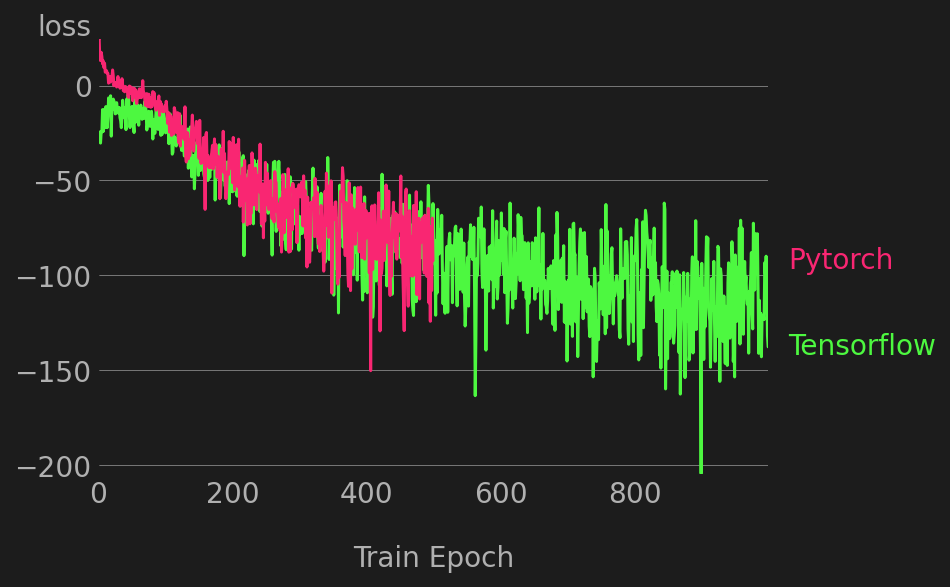

In [46]:
%matplotlib inline
plt.style.use('~/.config/matplotlib/stylelib/molokai.mplstyle')
plt.rcParams['image.cmap'] = 'viridis'
import matplotx

losses_arr_tf = np.stack(list(losses_tf.values())).flatten()

with plt.style.context(matplotx.styles.dufte):
    fig, ax = plt.subplots()
    _ = ax.plot(np.arange(len(losses_arr_tf)), losses_arr_tf, label='Tensorflow');
    _ = ax.plot(np.arange(len(losses_arr)), losses_arr, label='Pytorch');
    _ = ax.set_xlabel(r'Train Epoch')
    matplotx.ylabel_top("loss")  # move ylabel to the top, rotate
    matplotx.line_labels()  # line labels to the right